# **MLP with extended physics loss function**
# (Option 1: with PDEs numeric approximation - Eq2: Piecewise constant advection eq)


## **Running the models using the 'modelling' package**

A notebook through which different modelling configurations can be ran, using the ``modelling`` package. It follows the steps of:
- preparing packages;
- setting "global" variables;
- getting the data;
- defining hyperparameters;
- running a grid search and/or training a model; and
- evaluation.
In the modelling package, variations can be made to the models and training functions to experiment. Don't forget to restart the notebook after making changes there.



For loading models, go to the ``src/results/models``:
- Baseline NO2 2017 with MLP and MSE loss: ``best_mlp_no2_baseline.pth``

Option 1 Architecture
- Exp 1: NO2 2017 with MLP and option 1 simple physics loss: ``best_mlp_no2_linear.pth``
- Exp 2: NO2 2017 with MLP and option 1 pde numerical solver eq 1: ``best_mlp_no2_pde_numerical_eq1.pth``
- Exp 3: NO2 2017 with MLP and option 1 pde numerical solver eq 2: ``best_mlp_no2_pde_numerical_eq2.pth``


In [1]:
print("Starting script...")


from modelling.MLP import BasicMLP
from modelling import *


import optuna
import threading
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

Starting script...

Running __init__.py for data pipeline...
Modelling package initialized



Use GPU when available

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu


### **Set "global" variables**

In [3]:
Path.cwd()

PosixPath('/home/rachel/forecasting_smog_PEML/src')

In [4]:
HABROK = bool(0)                  # set to True if using HABROK; it will print
                                  # all stdout to a .txt file to log progress

BASE_DIR = Path.cwd().parents[0] # set it to the root directory of the project, not src
MODEL_PATH = BASE_DIR /"src" / "results" / "models"
MINMAX_PATH = BASE_DIR  / "data" / "data_combined" / "pollutants_minmax.csv"

print("BASE_DIR: ", BASE_DIR)
print("MODEL_PATH: ", MODEL_PATH)
print("MINMAX_PATH: ", MINMAX_PATH)

torch.manual_seed(34)             # set seed for reproducibility

N_HOURS_U = 24 * 3               # number of hours to use for input (number of days * 24 hours)
N_HOURS_Y = 24                    # number of hours to predict (1 day * 24 hours)
N_HOURS_STEP = 24                 # "sampling rate" in hours of the data; e.g. 24 
                                  # means sample an I/O-pair every 24 hours
                                  # the contaminants and meteorological vars

# Change this according to the data you want to use
YEARS = [2017]
TRAIN_YEARS = [2017]
VAL_YEARS = [2017]
TEST_YEARS = [2017]

# Description of the Loss functions to choose from
'''
"MSE" - simple mean squared error (baseline model)
"Physics_Linear_MSE" - MSE with a linear time shifting (from Tuindorp) to compute y_phy
"Physics_PDE_numerical_constant" - PDE loss function with numerical derivatives Equation 1: Constant advection equation
"Physics_PDE_numerical_piecewise" - PDE loss function with numerical derivatives Equation 2: Piecewise constant advection equation
'''


LOSS_FUNC = "Physics_PDE_numerical_piecewise" # choose from "MSE", "Physics_Linear_MSE", "Physics_PDE_numerical_constant", "Physics_PDE_numerical_piecewise"

BASE_DIR:  /home/rachel/forecasting_smog_PEML
MODEL_PATH:  /home/rachel/forecasting_smog_PEML/src/results/models
MINMAX_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/pollutants_minmax.csv


In [5]:
import math
# Define known coordinates
lat_tuindorp, lon_tuindorp = 52.10503, 5.12448 # Coordinates of Tuindorp based on valentijn thesis (52°06’18.1”N, 5°07’28.1”E) and converted
lat_breukelen, lon_breukelen = 52.20153, 4.98741 # Positioned at a 30° angle from Tuindorp 

def latlon_to_xy(lat1, lon1, lat2, lon2):
    """Convert lat/lon to approximate x, y in km using the equirectangular projection."""
    R = 6371  # Radius of Earth in km
    x = (lon2 - lon1) * (math.pi / 180) * R * math.cos(math.radians((lat1 + lat2) / 2))
    y = (lat2 - lat1) * (math.pi / 180) * R
    return x, y

# Convert to (x, y) in km
x_breukelen, y_breukelen = latlon_to_xy(lat_tuindorp, lon_tuindorp, lat_breukelen, lon_breukelen)
x_tuindorp, y_tuindorp = 0, 0  # Set Tuindorp as the origin
distance = math.sqrt(x_breukelen**2 + y_breukelen**2)
# print the coordinates of x y tuindorp and breukelen
print(f"Tuindorp: ({x_tuindorp:.2f}, {y_tuindorp:.2f})")
print(f"Breukelen: ({x_breukelen:.2f}, {y_breukelen:.2f})")
print(f"Distance between Tuindorp and Breukelen: {distance:.2f} km")

Tuindorp: (0.00, 0.00)
Breukelen: (-9.35, 10.73)
Distance between Tuindorp and Breukelen: 14.23 km


### **Load in data and create PyTorch *Datasets***

In [6]:
# Load in data and create PyTorch Datasets. To tune
# which exact .csv files get extracted, change the
# lists in the get_dataframes() definition

train_input_frames = get_dataframes('train', 'u', YEARS)
train_output_frames = get_dataframes('train', 'y', YEARS)

val_input_frames = get_dataframes('val', 'u', YEARS)
val_output_frames = get_dataframes('val', 'y', YEARS)

test_input_frames = get_dataframes('test', 'u', YEARS)
test_output_frames = get_dataframes('test', 'y', YEARS) 

print("Successfully loaded data")

Imported train_2017_combined_u.csv
Imported train_2017_combined_y.csv
Imported val_2017_combined_u.csv
Imported val_2017_combined_y.csv
Imported test_2017_combined_u.csv
Imported test_2017_combined_y.csv
Successfully loaded data


In [7]:
train_dataset = TimeSeriesDataset(
    train_input_frames,  # list of input training dataframes
    train_output_frames, # list of output training dataframes
    len(TRAIN_YEARS),                   # number of dataframes put in for both
                         # (basically len(train_input_frames) and
                         # len(train_output_frames) must be equal)
    N_HOURS_U,           # number of hours of input data
    N_HOURS_Y,           # number of hours of output data
    N_HOURS_STEP,        # number of hours between each input/output pair
)
val_dataset = TimeSeriesDataset(
    val_input_frames,    # etc.
    val_output_frames,
    len(VAL_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)
test_dataset = TimeSeriesDataset(
    test_input_frames,
    test_output_frames,
    len(TEST_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)

del train_input_frames, train_output_frames
del val_input_frames, val_output_frames
del test_input_frames, test_output_frames

In [8]:
train_dataset.u

[                           DD   FF        FH        FX       NO2         P  \
 DateTime                                                                     
 2017-08-01 00:00:00  0.166667  0.1  0.111111  0.000000  0.242115  0.562982   
 2017-08-01 01:00:00  0.000000  0.0  0.111111  0.052632  0.223158  0.570694   
 2017-08-01 02:00:00  0.000000  0.0  0.000000  0.000000  0.165911  0.560411   
 2017-08-01 03:00:00  0.277778  0.1  0.000000  0.000000  0.142363  0.555270   
 2017-08-01 04:00:00  0.805556  0.2  0.111111  0.105263  0.156297  0.555270   
 ...                       ...  ...       ...       ...       ...       ...   
 2017-11-16 19:00:00  0.750000  0.2  0.333333  0.210526  0.523871  0.789203   
 2017-11-16 20:00:00  0.972222  0.3  0.333333  0.421053  0.512314  0.814910   
 2017-11-16 21:00:00  0.888889  0.1  0.222222  0.263158  0.232880  0.827763   
 2017-11-16 22:00:00  0.944444  0.2  0.111111  0.105263  0.108123  0.832905   
 2017-11-16 23:00:00  0.861111  0.1  0.222222  0.105

In [9]:
train_dataset.y

[                          NO2
 DateTime                     
 2017-08-01 00:00:00  0.223698
 2017-08-01 01:00:00  0.145496
 2017-08-01 02:00:00  0.275978
 2017-08-01 03:00:00  0.423742
 2017-08-01 04:00:00  0.478721
 ...                       ...
 2017-11-16 19:00:00  0.606502
 2017-11-16 20:00:00  0.456470
 2017-11-16 21:00:00  0.483258
 2017-11-16 22:00:00  0.468784
 2017-11-16 23:00:00  0.473428
 
 [2592 rows x 1 columns]]

In [10]:
len(train_dataset.pairs[0][0])

72

In [11]:
train_dataset.pairs[0][0]

tensor([[0.1667, 0.1000, 0.1111, 0.0000, 0.2421, 0.5630, 0.0000, 0.5367, 0.7269],
        [0.0000, 0.0000, 0.1111, 0.0526, 0.2232, 0.5707, 0.0000, 0.5467, 0.7407],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1659, 0.5604, 0.0000, 0.5067, 0.6898],
        [0.2778, 0.1000, 0.0000, 0.0000, 0.1424, 0.5553, 0.0000, 0.4633, 0.6343],
        [0.8056, 0.2000, 0.1111, 0.1053, 0.1563, 0.5553, 0.0000, 0.4933, 0.6620],
        [0.0000, 0.0000, 0.1111, 0.1053, 0.3135, 0.5681, 0.3000, 0.6200, 0.7593],
        [0.7222, 0.1000, 0.1111, 0.0526, 0.5326, 0.5913, 0.0000, 0.6433, 0.7269],
        [0.7500, 0.1000, 0.1111, 0.1053, 0.5367, 0.5938, 0.0000, 0.6500, 0.7037],
        [0.7222, 0.2000, 0.2222, 0.1053, 0.5172, 0.5964, 0.0000, 0.6733, 0.6574],
        [0.7500, 0.2000, 0.2222, 0.2105, 0.4459, 0.5990, 0.3000, 0.7133, 0.6157],
        [0.6111, 0.2000, 0.2222, 0.1579, 0.3129, 0.6041, 0.0000, 0.7167, 0.6019],
        [0.6111, 0.2000, 0.2222, 0.1579, 0.3478, 0.6067, 0.0000, 0.7133, 0.5926],
        [0.6528,

In [12]:
train_dataset.pairs[0][1]

tensor([[0.1965],
        [0.1501],
        [0.1518],
        [0.2622],
        [0.5524],
        [0.4840],
        [0.3544],
        [0.2754],
        [0.1948],
        [0.1734],
        [0.1505],
        [0.1352],
        [0.0778],
        [0.1184],
        [0.1293],
        [0.1238],
        [0.1043],
        [0.0997],
        [0.0812],
        [0.0823],
        [0.1155],
        [0.0837],
        [0.0570],
        [0.1006]])

In [13]:
# Assuming train_dataset.u[0] is a pandas Index object with column names
column_names = list(train_dataset.u[0])  # Convert Index to list

# Now, find the indices of the columns 'NO2', 'DD', 'FH'
no2_idx = column_names.index('NO2')
dd_idx = column_names.index('DD')
fh_idx = column_names.index('FH')

print("NO2 index: ", no2_idx)
print("DD index (wind direction): ", dd_idx)
print("FH index (Hourly wind speed): ", fh_idx)


NO2 index:  4
DD index (wind direction):  0
FH index (Hourly wind speed):  2


In [14]:
train_dataset.u[0].iloc[:,no2_idx]

DateTime
2017-08-01 00:00:00    0.242115
2017-08-01 01:00:00    0.223158
2017-08-01 02:00:00    0.165911
2017-08-01 03:00:00    0.142363
2017-08-01 04:00:00    0.156297
                         ...   
2017-11-16 19:00:00    0.523871
2017-11-16 20:00:00    0.512314
2017-11-16 21:00:00    0.232880
2017-11-16 22:00:00    0.108123
2017-11-16 23:00:00    0.205120
Name: NO2, Length: 2592, dtype: float64

In [15]:
train_dataset.u[0].iloc[:,dd_idx]

DateTime
2017-08-01 00:00:00    0.166667
2017-08-01 01:00:00    0.000000
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.277778
2017-08-01 04:00:00    0.805556
                         ...   
2017-11-16 19:00:00    0.750000
2017-11-16 20:00:00    0.972222
2017-11-16 21:00:00    0.888889
2017-11-16 22:00:00    0.944444
2017-11-16 23:00:00    0.861111
Name: DD, Length: 2592, dtype: float64

In [16]:
train_dataset.u[0].iloc[:,fh_idx]

DateTime
2017-08-01 00:00:00    0.111111
2017-08-01 01:00:00    0.111111
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.000000
2017-08-01 04:00:00    0.111111
                         ...   
2017-11-16 19:00:00    0.333333
2017-11-16 20:00:00    0.333333
2017-11-16 21:00:00    0.222222
2017-11-16 22:00:00    0.111111
2017-11-16 23:00:00    0.222222
Name: FH, Length: 2592, dtype: float64

## **Computing y with the y_phy**

### **Start hyperparameter searching with Optuna**

In [17]:
def objective(trial):
    # Define hyperparameters to search over
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 5)
    n_hidden_units = trial.suggest_int("n_hidden_units", 32, 256)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])  # Match the original hp['batch_sz']
    lambda_phy = trial.suggest_loguniform("lambda_phy", 1e-5, 1e-1)

    # Create train & validation loaders (following the original code)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize MLP model
    model = BasicMLP(
        N_INPUT_UNITS=train_dataset.__n_features_in__(),
        N_HIDDEN_LAYERS=n_hidden_layers,
        N_HIDDEN_UNITS=n_hidden_units,
        N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
        loss_function=LOSS_FUNC,
    )

    # Train and return validation loss
    val_loss = model.train_model(train_loader, val_loader, epochs=50, lr=lr, weight_decay=weight_decay, lambda_phy = lambda_phy, device=device)
    
    return val_loss


# Run Optuna optimization
study = optuna.create_study(direction="minimize", study_name="mlp_hyperparameter_optimization_phy_pde_num_eq2", storage="sqlite:///mlp_hyperparameter_optimization_phy_pde.db", load_if_exists=True)

study.optimize(objective, n_trials=100)

# Print best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)




[I 2025-03-14 17:08:23,654] A new study created in RDB with name: mlp_hyperparameter_optimization_phy_pde_num_eq2
/tmp/ipykernel_6748/831535804.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
/tmp/ipykernel_6748/831535804.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
/tmp/ipykernel_6748/831535804.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_phy = trial.suggest_loguniform("la

Epoch 1/50
Phy loss tensor(0.3503, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0592, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0624, grad_fn=<AddBackward0>)
Phy loss tensor(0.3710, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0724, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0758, grad_fn=<AddBackward0>)
Phy loss tensor(0.3437, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0966, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0997, grad_fn=<AddBackward0>)
Phy loss tensor(0.3038, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0823, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0851, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.080717 - Val Loss (DD rmse only): 0.360070
Epoch 2/50
Phy loss tensor(0.3358, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0727, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0757, grad_fn=<AddBackward0>)
Phy loss tensor(0.2341, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0576, grad_fn=<MseLossB

[I 2025-03-14 17:09:18,823] Trial 0 finished with value: 0.14091745018959045 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 208, 'lr': 0.0001675107919310246, 'weight_decay': 9.352211768541936e-06, 'batch_size': 32, 'lambda_phy': 0.009013566871754553}. Best is trial 0 with value: 0.14091745018959045.


Epoch 50/50 - Train Loss: 0.015772 - Val Loss (DD rmse only): 0.142505


/tmp/ipykernel_6748/831535804.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
/tmp/ipykernel_6748/831535804.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
/tmp/ipykernel_6748/831535804.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_phy = trial.suggest_loguniform("lambda_phy", 1e-5, 1e-1)


Epoch 1/50
Phy loss tensor(0.4393, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0791, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0863, grad_fn=<AddBackward0>)
Phy loss tensor(0.2930, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0926, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0974, grad_fn=<AddBackward0>)
Phy loss tensor(0.3273, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0502, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0556, grad_fn=<AddBackward0>)
Phy loss tensor(0.3788, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0834, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0895, grad_fn=<AddBackward0>)
Phy loss tensor(0.2546, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0623, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0665, grad_fn=<AddBackward0>)
Phy loss tensor(0.3702, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0849, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0909, grad_fn=<AddBackward0>)
Phy loss te

[I 2025-03-14 17:10:41,880] Trial 1 finished with value: 0.21054629236459732 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 177, 'lr': 1.2517297783729625e-05, 'weight_decay': 1.2755009135468582e-06, 'batch_size': 16, 'lambda_phy': 0.016317988982900565}. Best is trial 0 with value: 0.14091745018959045.


Epoch 50/50 - Train Loss: 0.031660 - Val Loss (DD rmse only): 0.210546
Epoch 1/50
Phy loss tensor(0.5504, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0950, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0950, grad_fn=<AddBackward0>)
Phy loss tensor(0.4227, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0623, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0623, grad_fn=<AddBackward0>)
Phy loss tensor(0.3281, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0914, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0915, grad_fn=<AddBackward0>)
Phy loss tensor(0.2430, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0592, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0592, grad_fn=<AddBackward0>)
Phy loss tensor(0.2253, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0453, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0453, grad_fn=<AddBackward0>)
Phy loss tensor(0.1305, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0354, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:12:29,251] Trial 2 finished with value: 0.14261749883492789 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 230, 'lr': 0.0006358611503085658, 'weight_decay': 4.307624933728204e-07, 'batch_size': 8, 'lambda_phy': 4.923754916947465e-05}. Best is trial 0 with value: 0.14091745018959045.


Epoch 50/50 - Train Loss: 0.012056 - Val Loss (DD rmse only): 0.167808
Epoch 1/50
Phy loss tensor(0.2848, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0631, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0636, grad_fn=<AddBackward0>)
Phy loss tensor(0.3182, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0406, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0412, grad_fn=<AddBackward0>)
Phy loss tensor(0.2834, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0489, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0494, grad_fn=<AddBackward0>)
Phy loss tensor(0.2589, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0582, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0587, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.053224 - Val Loss (DD rmse only): 0.264780
Epoch 2/50
Phy loss tensor(0.2117, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0349, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0353, grad_fn=<AddBackward0>)
Phy loss tensor(0.2340

[I 2025-03-14 17:13:17,437] Trial 3 finished with value: 0.14185023307800293 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 38, 'lr': 0.0028454462164799878, 'weight_decay': 1.847269783719288e-06, 'batch_size': 32, 'lambda_phy': 0.001787789154313003}. Best is trial 0 with value: 0.14091745018959045.


Epoch 1/50
Phy loss tensor(0.5969, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1502, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1517, grad_fn=<AddBackward0>)
Phy loss tensor(0.2794, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0463, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0470, grad_fn=<AddBackward0>)
Phy loss tensor(0.1953, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0222, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0227, grad_fn=<AddBackward0>)
Phy loss tensor(0.1698, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0362, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0366, grad_fn=<AddBackward0>)
Phy loss tensor(0.1407, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0451, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0454, grad_fn=<AddBackward0>)
Phy loss tensor(0.1728, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0298, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0303, grad_fn=<AddBackward0>)
Phy loss te

[I 2025-03-14 17:14:32,848] Trial 4 finished with value: 0.1425551399588585 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 201, 'lr': 0.001968156347429111, 'weight_decay': 3.436209373917315e-07, 'batch_size': 16, 'lambda_phy': 0.0024912210549769527}. Best is trial 0 with value: 0.14091745018959045.


Phy loss tensor(0.1818, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0140, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0144, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.013182 - Val Loss (DD rmse only): 0.171874
Epoch 1/50
Phy loss tensor(0.2527, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0928, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0929, grad_fn=<AddBackward0>)
Phy loss tensor(0.4149, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0543, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0544, grad_fn=<AddBackward0>)
Phy loss tensor(0.3687, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0251, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0252, grad_fn=<AddBackward0>)
Phy loss tensor(0.3078, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0350, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0350, grad_fn=<AddBackward0>)
Phy loss tensor(0.2627, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0300, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:15:59,527] Trial 5 finished with value: 0.14174733062585196 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 41, 'lr': 0.0033548012664890345, 'weight_decay': 7.96300788632123e-08, 'batch_size': 8, 'lambda_phy': 0.00025433539377321045}. Best is trial 0 with value: 0.14091745018959045.


Epoch 1/50
Phy loss tensor(0.4292, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1239, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1265, grad_fn=<AddBackward0>)
Phy loss tensor(0.3944, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0871, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0895, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.108035 - Val Loss (DD rmse only): 0.425134
Epoch 2/50
Phy loss tensor(0.3888, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1125, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1149, grad_fn=<AddBackward0>)
Phy loss tensor(0.4260, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0879, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0905, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Loss: 0.102713 - Val Loss (DD rmse only): 0.415570
Epoch 3/50
Phy loss tensor(0.4140, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1060, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1086, grad_fn=<AddBackward0>)
Phy loss ten

[I 2025-03-14 17:17:06,683] Trial 6 finished with value: 0.19722634553909302 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 247, 'lr': 8.937231899609748e-05, 'weight_decay': 2.3886743704907363e-06, 'batch_size': 64, 'lambda_phy': 0.00620694436107831}. Best is trial 0 with value: 0.14091745018959045.


Epoch 1/50
Phy loss tensor(0.5231, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1612, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1614, grad_fn=<AddBackward0>)
Phy loss tensor(0.3525, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0878, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0880, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.124682 - Val Loss (DD rmse only): 0.300276
Epoch 2/50
Phy loss tensor(0.2509, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0340, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0341, grad_fn=<AddBackward0>)
Phy loss tensor(0.1412, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0506, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0507, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Loss: 0.042401 - Val Loss (DD rmse only): 0.214450
Epoch 3/50
Phy loss tensor(0.1394, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0574, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0575, grad_fn=<AddBackward0>)
Phy loss ten

[I 2025-03-14 17:18:17,131] Trial 7 finished with value: 0.14307743310928345 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 93, 'lr': 0.003800775536211022, 'weight_decay': 5.772177808644573e-07, 'batch_size': 64, 'lambda_phy': 0.0003970193884392467}. Best is trial 0 with value: 0.14091745018959045.


Phy loss tensor(0.2075, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0155, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0156, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.014304 - Val Loss (DD rmse only): 0.144337
Epoch 1/50
Phy loss tensor(0.4938, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1154, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1156, grad_fn=<AddBackward0>)
Phy loss tensor(0.3563, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1061, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1062, grad_fn=<AddBackward0>)
Phy loss tensor(0.3988, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1168, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1169, grad_fn=<AddBackward0>)
Phy loss tensor(0.4088, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0916, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0917, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.107607 - Val Loss (DD rmse only): 0.403342
Epoch 2/50
Phy loss tensor(0.3183

[I 2025-03-14 17:19:25,401] Trial 8 finished with value: 0.14317622780799866 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 169, 'lr': 0.00027656459781163193, 'weight_decay': 6.592392348072942e-07, 'batch_size': 32, 'lambda_phy': 0.0003624843328686254}. Best is trial 0 with value: 0.14091745018959045.


Epoch 1/50
Phy loss tensor(0.4805, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1289, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1289, grad_fn=<AddBackward0>)
Phy loss tensor(0.4167, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0777, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0777, grad_fn=<AddBackward0>)
Phy loss tensor(0.1922, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0321, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0321, grad_fn=<AddBackward0>)
Phy loss tensor(0.2059, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0434, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0434, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.070503 - Val Loss (DD rmse only): 0.213994
Epoch 2/50
Phy loss tensor(0.1699, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0357, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0357, grad_fn=<AddBackward0>)
Phy loss tensor(0.1615, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0472, grad_fn=<MseLossB

[I 2025-03-14 17:20:23,589] Trial 9 finished with value: 0.14384236931800842 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 124, 'lr': 0.0019281159422967211, 'weight_decay': 1.277890221008526e-07, 'batch_size': 32, 'lambda_phy': 1.3968052195018058e-05}. Best is trial 0 with value: 0.14091745018959045.


Epoch 1/50
Phy loss tensor(0.4382, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1107, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1243, grad_fn=<AddBackward0>)
Phy loss tensor(0.4011, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1164, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1288, grad_fn=<AddBackward0>)
Phy loss tensor(0.4237, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1132, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1264, grad_fn=<AddBackward0>)
Phy loss tensor(0.3993, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0960, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1084, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.121982 - Val Loss (DD rmse only): 0.430060
Epoch 2/50
Phy loss tensor(0.3698, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0957, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1072, grad_fn=<AddBackward0>)
Phy loss tensor(0.3772, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0955, grad_fn=<MseLossB

[I 2025-03-14 17:21:22,157] Trial 10 finished with value: 0.22783251106739044 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 127, 'lr': 4.50339330105605e-05, 'weight_decay': 7.99773085648807e-05, 'batch_size': 32, 'lambda_phy': 0.03109747225518402}. Best is trial 0 with value: 0.14091745018959045.


Epoch 50/50 - Train Loss: 0.033451 - Val Loss (DD rmse only): 0.227833
Epoch 1/50
Phy loss tensor(0.3603, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1210, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1210, grad_fn=<AddBackward0>)
Phy loss tensor(0.2159, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0953, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0953, grad_fn=<AddBackward0>)
Phy loss tensor(0.6067, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1130, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1131, grad_fn=<AddBackward0>)
Phy loss tensor(0.4136, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0644, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0644, grad_fn=<AddBackward0>)
Phy loss tensor(0.3273, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1004, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1004, grad_fn=<AddBackward0>)
Phy loss tensor(0.3817, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1506, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:23:13,301] Trial 11 finished with value: 0.1470976322889328 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 77, 'lr': 0.00036562400377099295, 'weight_decay': 1.2728855545041463e-08, 'batch_size': 8, 'lambda_phy': 9.771719299694979e-05}. Best is trial 0 with value: 0.14091745018959045.


Epoch 50/50 - Train Loss: 0.013826 - Val Loss (DD rmse only): 0.152401
Epoch 1/50
Phy loss tensor(0.3416, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1082, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1084, grad_fn=<AddBackward0>)
Phy loss tensor(0.3314, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1380, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1382, grad_fn=<AddBackward0>)
Phy loss tensor(0.5024, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0714, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0717, grad_fn=<AddBackward0>)
Phy loss tensor(0.3380, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1238, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1240, grad_fn=<AddBackward0>)
Phy loss tensor(0.4052, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0974, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0976, grad_fn=<AddBackward0>)
Phy loss tensor(0.3172, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0864, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:24:33,649] Trial 12 finished with value: 0.17993058760960898 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 38, 'lr': 0.00010925043743116577, 'weight_decay': 4.812929913958221e-05, 'batch_size': 8, 'lambda_phy': 0.0005714275857562202}. Best is trial 0 with value: 0.14091745018959045.


Phy loss tensor(0.0498, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0204, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0204, grad_fn=<AddBackward0>)
Phy loss tensor(0.2527, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0202, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0203, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.019143 - Val Loss (DD rmse only): 0.179931
Epoch 1/50
Phy loss tensor(0.2249, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1442, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1454, grad_fn=<AddBackward0>)
Phy loss tensor(0.1337, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2331, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2338, grad_fn=<AddBackward0>)
Phy loss tensor(0.2764, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0565, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0579, grad_fn=<AddBackward0>)
Phy loss tensor(0.3194, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0384, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:27:25,259] Trial 13 finished with value: 0.144931490222613 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 217, 'lr': 0.009806770426843773, 'weight_decay': 1.5274988525676158e-05, 'batch_size': 8, 'lambda_phy': 0.005218827050115181}. Best is trial 0 with value: 0.14091745018959045.


Epoch 50/50 - Train Loss: 0.014186 - Val Loss (DD rmse only): 0.181931
Epoch 1/50
Phy loss tensor(0.3595, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1105, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1424, grad_fn=<AddBackward0>)
Phy loss tensor(0.2653, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0822, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1058, grad_fn=<AddBackward0>)
Phy loss tensor(0.3866, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0377, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0720, grad_fn=<AddBackward0>)
Phy loss tensor(0.2687, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0620, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0859, grad_fn=<AddBackward0>)
Phy loss tensor(0.3249, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0322, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0611, grad_fn=<AddBackward0>)
Phy loss tensor(0.1931, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0343, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:28:48,277] Trial 14 finished with value: 0.1429469734430313 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 166, 'lr': 0.0008595839563874304, 'weight_decay': 0.0009982691551487803, 'batch_size': 8, 'lambda_phy': 0.08886290629595095}. Best is trial 0 with value: 0.14091745018959045.


Phy loss tensor(0.1930, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0158, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0330, grad_fn=<AddBackward0>)
Phy loss tensor(0.1849, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0114, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0278, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.032264 - Val Loss (DD rmse only): 0.142947
Epoch 1/50
Phy loss tensor(0.3975, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0907, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0908, grad_fn=<AddBackward0>)
Phy loss tensor(0.2389, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0380, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0380, grad_fn=<AddBackward0>)
Phy loss tensor(0.1292, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1470, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1470, grad_fn=<AddBackward0>)
Phy loss tensor(0.1951, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0471, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:29:23,525] Trial 15 finished with value: 0.14031608402729034 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 102, 'lr': 0.008778016668055269, 'weight_decay': 1.3667246553899201e-08, 'batch_size': 32, 'lambda_phy': 0.00018727322543973194}. Best is trial 15 with value: 0.14031608402729034.


Phy loss tensor(0.1849, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0148, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0149, grad_fn=<AddBackward0>)
Phy loss tensor(0.2601, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0127, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0127, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.013182 - Val Loss (DD rmse only): 0.149972
Epoch 1/50
Phy loss tensor(0.5005, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1880, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1880, grad_fn=<AddBackward0>)
Phy loss tensor(0.4458, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1442, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1442, grad_fn=<AddBackward0>)
Phy loss tensor(0.5785, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1608, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1608, grad_fn=<AddBackward0>)
Phy loss tensor(0.5652, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1737, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:30:00,591] Trial 16 finished with value: 0.38774028420448303 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 86, 'lr': 2.536473846321896e-05, 'weight_decay': 9.559107457621942e-06, 'batch_size': 32, 'lambda_phy': 8.141716717274788e-05}. Best is trial 15 with value: 0.14031608402729034.


Phy loss tensor(0.3695, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0892, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0892, grad_fn=<AddBackward0>)
Phy loss tensor(0.3168, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0740, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0741, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.082373 - Val Loss (DD rmse only): 0.387740
Epoch 1/50
Phy loss tensor(0.4915, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1748, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1748, grad_fn=<AddBackward0>)
Phy loss tensor(0.5190, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1705, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1705, grad_fn=<AddBackward0>)
Phy loss tensor(0.5407, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1755, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1755, grad_fn=<AddBackward0>)
Phy loss tensor(0.6067, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1539, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:30:36,365] Trial 17 finished with value: 0.15962685644626617 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 144, 'lr': 0.00013333641772715418, 'weight_decay': 1.171599181730546e-08, 'batch_size': 32, 'lambda_phy': 1.974521783510135e-05}. Best is trial 15 with value: 0.14031608402729034.


Phy loss tensor(0.2186, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0131, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0131, grad_fn=<AddBackward0>)
Phy loss tensor(0.1258, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0132, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0132, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.015398 - Val Loss (DD rmse only): 0.159627
Epoch 1/50
Phy loss tensor(0.5234, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2138, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2144, grad_fn=<AddBackward0>)
Phy loss tensor(0.1552, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0318, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0320, grad_fn=<AddBackward0>)
Phy loss tensor(0.1206, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0740, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0741, grad_fn=<AddBackward0>)
Phy loss tensor(0.1460, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0523, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:31:01,512] Trial 18 finished with value: 0.14131395518779755 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 106, 'lr': 0.008505016308657585, 'weight_decay': 0.00013310976443561343, 'batch_size': 32, 'lambda_phy': 0.0011400931591071676}. Best is trial 15 with value: 0.14031608402729034.


Phy loss tensor(0.1788, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0138, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0140, grad_fn=<AddBackward0>)
Phy loss tensor(0.2667, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0121, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0124, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.014061 - Val Loss (DD rmse only): 0.145026
Epoch 1/50
Phy loss tensor(0.3796, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1036, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1087, grad_fn=<AddBackward0>)
Phy loss tensor(0.4095, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0993, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1048, grad_fn=<AddBackward0>)
Phy loss tensor(0.4211, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0793, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0850, grad_fn=<AddBackward0>)
Phy loss tensor(0.1688, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0897, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:31:32,657] Trial 19 finished with value: 0.14208737015724182 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 194, 'lr': 0.00024089144048398102, 'weight_decay': 8.401563631788307e-06, 'batch_size': 32, 'lambda_phy': 0.01348506210266253}. Best is trial 15 with value: 0.14031608402729034.


Phy loss tensor(0.0953, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0238, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0251, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.018752 - Val Loss (DD rmse only): 0.142198
Epoch 1/50
Phy loss tensor(0.4233, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1122, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1352, grad_fn=<AddBackward0>)
Phy loss tensor(0.3822, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0938, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1146, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.124906 - Val Loss (DD rmse only): 0.358244
Epoch 2/50
Phy loss tensor(0.3402, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0655, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0840, grad_fn=<AddBackward0>)
Phy loss tensor(0.2505, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0445, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0581, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-14 17:32:11,120] Trial 20 finished with value: 0.13909611105918884 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 250, 'lr': 0.0008826257915608811, 'weight_decay': 4.165680464234988e-08, 'batch_size': 64, 'lambda_phy': 0.054427600520664386}. Best is trial 20 with value: 0.13909611105918884.


Phy loss tensor(0.1644, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0133, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0222, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.023990 - Val Loss (DD rmse only): 0.140654
Epoch 1/50
Phy loss tensor(0.4374, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1171, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1580, grad_fn=<AddBackward0>)
Phy loss tensor(0.3686, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0904, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1248, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.141395 - Val Loss (DD rmse only): 0.379193
Epoch 2/50
Phy loss tensor(0.3477, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0712, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1037, grad_fn=<AddBackward0>)
Phy loss tensor(0.3194, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0690, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0989, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-14 17:32:45,271] Trial 21 finished with value: 0.1407219022512436 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 220, 'lr': 0.0009130104735664519, 'weight_decay': 4.051403618922909e-08, 'batch_size': 64, 'lambda_phy': 0.09345044806294664}. Best is trial 20 with value: 0.13909611105918884.


Phy loss tensor(0.1873, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0158, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0333, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.032181 - Val Loss (DD rmse only): 0.141843
Epoch 1/50
Phy loss tensor(0.5739, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1954, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2418, grad_fn=<AddBackward0>)
Phy loss tensor(0.4837, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1582, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1972, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.219510 - Val Loss (DD rmse only): 0.479131
Epoch 2/50
Phy loss tensor(0.4851, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1252, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1643, grad_fn=<AddBackward0>)
Phy loss tensor(0.3921, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1318, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1635, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-14 17:33:18,889] Trial 22 finished with value: 0.1406373232603073 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 250, 'lr': 0.0006745970842830138, 'weight_decay': 4.929209159370921e-08, 'batch_size': 64, 'lambda_phy': 0.08075901630801541}. Best is trial 20 with value: 0.13909611105918884.


Phy loss tensor(0.1793, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0130, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0274, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.029701 - Val Loss (DD rmse only): 0.141985
Epoch 1/50
Phy loss tensor(0.4551, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1250, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1477, grad_fn=<AddBackward0>)
Phy loss tensor(0.3859, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1021, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1213, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.134499 - Val Loss (DD rmse only): 0.397159
Epoch 2/50
Phy loss tensor(0.3559, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0840, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1017, grad_fn=<AddBackward0>)
Phy loss tensor(0.3664, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0767, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0949, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-14 17:33:54,704] Trial 23 finished with value: 0.14006072282791138 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 256, 'lr': 0.0005100192513583335, 'weight_decay': 3.205711025137794e-08, 'batch_size': 64, 'lambda_phy': 0.04977393948221662}. Best is trial 20 with value: 0.13909611105918884.


Phy loss tensor(0.1444, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0160, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0231, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.023929 - Val Loss (DD rmse only): 0.141554
Epoch 1/50
Phy loss tensor(0.5448, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1685, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1896, grad_fn=<AddBackward0>)
Phy loss tensor(0.3716, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1051, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1195, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.154551 - Val Loss (DD rmse only): 0.315921
Epoch 2/50
Phy loss tensor(0.2705, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0509, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0613, grad_fn=<AddBackward0>)
Phy loss tensor(0.1760, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0347, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0416, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-14 17:34:27,147] Trial 24 finished with value: 0.13983823359012604 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 256, 'lr': 0.0014241423919532745, 'weight_decay': 2.3980609888502052e-08, 'batch_size': 64, 'lambda_phy': 0.03873545172409654}. Best is trial 20 with value: 0.13909611105918884.


Phy loss tensor(0.1959, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0133, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0209, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.021273 - Val Loss (DD rmse only): 0.143302
Epoch 1/50
Phy loss tensor(0.4798, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1580, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1786, grad_fn=<AddBackward0>)
Phy loss tensor(0.4139, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0924, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1101, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.144397 - Val Loss (DD rmse only): 0.321573
Epoch 2/50
Phy loss tensor(0.3058, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0473, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0605, grad_fn=<AddBackward0>)
Phy loss tensor(0.1543, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0361, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0427, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-14 17:35:01,133] Trial 25 finished with value: 0.14036886394023895 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 256, 'lr': 0.0016347062335033541, 'weight_decay': 1.97157250735876e-07, 'batch_size': 64, 'lambda_phy': 0.04293618023169965}. Best is trial 20 with value: 0.13909611105918884.


Phy loss tensor(0.1975, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0118, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0202, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.021904 - Val Loss (DD rmse only): 0.143105
Epoch 1/50
Phy loss tensor(0.3984, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1231, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1350, grad_fn=<AddBackward0>)
Phy loss tensor(0.4747, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1054, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1196, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.127329 - Val Loss (DD rmse only): 0.418148
Epoch 2/50
Phy loss tensor(0.3815, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0945, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1059, grad_fn=<AddBackward0>)
Phy loss tensor(0.4070, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0997, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1119, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-14 17:35:38,438] Trial 26 finished with value: 0.14051169157028198 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 235, 'lr': 0.0004286755174704506, 'weight_decay': 3.519552868757944e-08, 'batch_size': 64, 'lambda_phy': 0.02995133750638487}. Best is trial 20 with value: 0.13909611105918884.


Phy loss tensor(0.2094, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0124, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0187, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.020106 - Val Loss (DD rmse only): 0.140512
Epoch 1/50
Phy loss tensor(0.5737, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2250, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2500, grad_fn=<AddBackward0>)
Phy loss tensor(0.4904, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1221, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1434, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.196678 - Val Loss (DD rmse only): 0.427628
Epoch 2/50
Phy loss tensor(0.4559, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0895, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1094, grad_fn=<AddBackward0>)
Phy loss tensor(0.2555, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0861, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0972, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-14 17:36:08,327] Trial 27 finished with value: 0.14008189737796783 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 234, 'lr': 0.001160626038203764, 'weight_decay': 2.604586270496816e-08, 'batch_size': 64, 'lambda_phy': 0.04347668127577974}. Best is trial 20 with value: 0.13909611105918884.


Phy loss tensor(0.2085, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0143, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0234, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.022739 - Val Loss (DD rmse only): 0.144277
Epoch 1/50
Phy loss tensor(0.5322, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1626, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1724, grad_fn=<AddBackward0>)
Phy loss tensor(0.4551, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1521, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1604, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.166394 - Val Loss (DD rmse only): 0.469878
Epoch 2/50
Phy loss tensor(0.4560, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1393, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1477, grad_fn=<AddBackward0>)
Phy loss tensor(0.4414, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1124, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1205, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-14 17:36:39,613] Trial 28 finished with value: 0.14602030813694 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 188, 'lr': 0.00047917210320430257, 'weight_decay': 1.281130286161572e-07, 'batch_size': 64, 'lambda_phy': 0.018336827829099317}. Best is trial 20 with value: 0.13909611105918884.


Phy loss tensor(0.2059, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0132, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0169, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.018495 - Val Loss (DD rmse only): 0.146020
Epoch 1/50
Phy loss tensor(0.4473, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0950, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0981, grad_fn=<AddBackward0>)
Phy loss tensor(0.2944, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0949, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0969, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.097540 - Val Loss (DD rmse only): 0.396612
Epoch 2/50
Phy loss tensor(0.3649, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0908, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0934, grad_fn=<AddBackward0>)
Phy loss tensor(0.3766, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0775, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0802, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-14 17:37:07,250] Trial 29 finished with value: 0.14804893732070923 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 211, 'lr': 0.0001941357389884588, 'weight_decay': 7.849689133687286e-08, 'batch_size': 64, 'lambda_phy': 0.007068521308675195}. Best is trial 20 with value: 0.13909611105918884.


Phy loss tensor(0.1980, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0143, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0157, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.016567 - Val Loss (DD rmse only): 0.148049
Epoch 1/50
Phy loss tensor(0.4835, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1223, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1241, grad_fn=<AddBackward0>)
Phy loss tensor(0.3243, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0942, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0954, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.109762 - Val Loss (DD rmse only): 0.342422
Epoch 2/50
Phy loss tensor(0.3124, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0635, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0647, grad_fn=<AddBackward0>)
Phy loss tensor(0.2422, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0332, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0341, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-14 17:37:40,151] Trial 30 finished with value: 0.1450837105512619 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 240, 'lr': 0.0013512183678296246, 'weight_decay': 2.7214416819549373e-08, 'batch_size': 64, 'lambda_phy': 0.0037492316212255875}. Best is trial 20 with value: 0.13909611105918884.


Phy loss tensor(0.1996, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0126, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0134, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.014228 - Val Loss (DD rmse only): 0.148975
Epoch 1/50
Phy loss tensor(0.5186, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1794, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2041, grad_fn=<AddBackward0>)
Phy loss tensor(0.4699, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1250, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1474, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.175751 - Val Loss (DD rmse only): 0.412449
Epoch 2/50
Phy loss tensor(0.3617, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0911, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1083, grad_fn=<AddBackward0>)
Phy loss tensor(0.3482, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0647, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0813, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-14 17:38:10,201] Trial 31 finished with value: 0.13831979036331177 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 230, 'lr': 0.0009968757159375455, 'weight_decay': 2.4818566393854494e-08, 'batch_size': 64, 'lambda_phy': 0.04765237731417435}. Best is trial 31 with value: 0.13831979036331177.


Phy loss tensor(0.1702, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0128, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0209, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.023099 - Val Loss (DD rmse only): 0.140344
Epoch 1/50
Phy loss tensor(0.4365, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1363, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1420, grad_fn=<AddBackward0>)
Phy loss tensor(0.1608, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0428, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0449, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.093429 - Val Loss (DD rmse only): 0.288555
Epoch 2/50
Phy loss tensor(0.2692, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0373, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0408, grad_fn=<AddBackward0>)
Phy loss tensor(0.2216, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0344, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0373, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-14 17:38:41,295] Trial 32 finished with value: 0.14084123075008392 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 255, 'lr': 0.004392022608604457, 'weight_decay': 1.9374641337420393e-08, 'batch_size': 64, 'lambda_phy': 0.012995235866882596}. Best is trial 31 with value: 0.13831979036331177.


Phy loss tensor(0.1901, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0136, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0160, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.015716 - Val Loss (DD rmse only): 0.154149
Epoch 1/50
Phy loss tensor(0.5403, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1214, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1472, grad_fn=<AddBackward0>)
Phy loss tensor(0.3597, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0983, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1155, grad_fn=<AddBackward0>)
Phy loss tensor(0.4228, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0956, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1158, grad_fn=<AddBackward0>)
Phy loss tensor(0.2993, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0856, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0999, grad_fn=<AddBackward0>)
Phy loss tensor(0.3342, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0387, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:39:24,181] Trial 33 finished with value: 0.1398351639509201 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 228, 'lr': 0.0006044292338322271, 'weight_decay': 2.2703674258924002e-07, 'batch_size': 16, 'lambda_phy': 0.04784462150565784}. Best is trial 31 with value: 0.13831979036331177.


Epoch 50/50 - Train Loss: 0.022678 - Val Loss (DD rmse only): 0.151541
Epoch 1/50
Phy loss tensor(0.5150, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1352, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1466, grad_fn=<AddBackward0>)
Phy loss tensor(0.4056, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1214, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1303, grad_fn=<AddBackward0>)
Phy loss tensor(0.2607, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0493, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0550, grad_fn=<AddBackward0>)
Phy loss tensor(0.2628, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0463, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0521, grad_fn=<AddBackward0>)
Phy loss tensor(0.2231, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0463, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0512, grad_fn=<AddBackward0>)
Phy loss tensor(0.1421, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0510, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:40:04,865] Trial 34 finished with value: 0.14191778749227524 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 223, 'lr': 0.0009698135479350604, 'weight_decay': 2.2675612038919378e-07, 'batch_size': 16, 'lambda_phy': 0.022098323724917678}. Best is trial 31 with value: 0.13831979036331177.


Phy loss tensor(0.1924, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0118, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0161, grad_fn=<AddBackward0>)
Phy loss tensor(0.2310, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0097, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0149, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.017304 - Val Loss (DD rmse only): 0.150576
Epoch 1/50
Phy loss tensor(0.3846, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0868, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0913, grad_fn=<AddBackward0>)
Phy loss tensor(0.1680, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0377, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0396, grad_fn=<AddBackward0>)
Phy loss tensor(0.1349, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1145, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1161, grad_fn=<AddBackward0>)
Phy loss tensor(0.2093, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0297, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:40:48,167] Trial 35 finished with value: 0.14299048483371735 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 207, 'lr': 0.0027595425410109676, 'weight_decay': 5.970331685372486e-08, 'batch_size': 16, 'lambda_phy': 0.011543957764519955}. Best is trial 31 with value: 0.13831979036331177.


Phy loss tensor(0.1936, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0145, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0168, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.014566 - Val Loss (DD rmse only): 0.167648
Epoch 1/50
Phy loss tensor(0.4558, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1309, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1541, grad_fn=<AddBackward0>)
Phy loss tensor(0.2977, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0839, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0990, grad_fn=<AddBackward0>)
Phy loss tensor(0.3395, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0650, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0823, grad_fn=<AddBackward0>)
Phy loss tensor(0.3443, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0793, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0968, grad_fn=<AddBackward0>)
Phy loss tensor(0.3371, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0409, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:41:25,908] Trial 36 finished with value: 0.1390385702252388 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 228, 'lr': 0.0006560340086640689, 'weight_decay': 1.1167203983431859e-07, 'batch_size': 16, 'lambda_phy': 0.0508283782956716}. Best is trial 31 with value: 0.13831979036331177.


Phy loss tensor(0.2019, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0149, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0251, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.023541 - Val Loss (DD rmse only): 0.143022
Epoch 1/50
Phy loss tensor(0.2739, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0961, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1130, grad_fn=<AddBackward0>)
Phy loss tensor(0.3298, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0882, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1086, grad_fn=<AddBackward0>)
Phy loss tensor(0.2761, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0532, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0702, grad_fn=<AddBackward0>)
Phy loss tensor(0.2699, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0386, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0552, grad_fn=<AddBackward0>)
Phy loss tensor(0.2530, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0283, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:42:00,043] Trial 37 finished with value: 0.13912639766931534 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 184, 'lr': 0.0006533731231431114, 'weight_decay': 9.391355714782766e-07, 'batch_size': 16, 'lambda_phy': 0.06168875148907901}. Best is trial 31 with value: 0.13831979036331177.


Epoch 50/50 - Train Loss: 0.025972 - Val Loss (DD rmse only): 0.141466
Epoch 1/50
Phy loss tensor(0.5056, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1808, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1907, grad_fn=<AddBackward0>)
Phy loss tensor(0.4416, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1545, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1632, grad_fn=<AddBackward0>)
Phy loss tensor(0.4447, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1584, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1671, grad_fn=<AddBackward0>)
Phy loss tensor(0.5298, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1363, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1467, grad_fn=<AddBackward0>)
Phy loss tensor(0.5735, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1479, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1591, grad_fn=<AddBackward0>)
Phy loss tensor(0.4411, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1374, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:42:35,089] Trial 38 finished with value: 0.2606535702943802 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 180, 'lr': 1.0148650443275641e-05, 'weight_decay': 1.1685314703819675e-06, 'batch_size': 16, 'lambda_phy': 0.019561111228284477}. Best is trial 31 with value: 0.13831979036331177.


Phy loss tensor(0.2081, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0367, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0408, grad_fn=<AddBackward0>)
Phy loss tensor(0.2237, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0409, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0452, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.042435 - Val Loss (DD rmse only): 0.260654
Epoch 1/50
Phy loss tensor(0.4332, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1408, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1724, grad_fn=<AddBackward0>)
Phy loss tensor(0.4858, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1819, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2173, grad_fn=<AddBackward0>)
Phy loss tensor(0.3850, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0968, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1249, grad_fn=<AddBackward0>)
Phy loss tensor(0.4607, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0883, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:43:08,926] Trial 39 finished with value: 0.14085200428962708 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 158, 'lr': 0.00031827776826672086, 'weight_decay': 1.0460466461311864e-06, 'batch_size': 16, 'lambda_phy': 0.07297886466657355}. Best is trial 31 with value: 0.13831979036331177.


Epoch 1/50
Phy loss tensor(0.5832, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1911, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1930, grad_fn=<AddBackward0>)
Phy loss tensor(0.2903, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0596, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0605, grad_fn=<AddBackward0>)
Phy loss tensor(0.1320, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0716, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0720, grad_fn=<AddBackward0>)
Phy loss tensor(0.1205, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0784, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0788, grad_fn=<AddBackward0>)
Phy loss tensor(0.1154, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0707, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0711, grad_fn=<AddBackward0>)
Phy loss tensor(0.1713, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0351, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0356, grad_fn=<AddBackward0>)
Phy loss te

[I 2025-03-14 17:43:38,763] Trial 40 finished with value: 0.14301519840955734 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 198, 'lr': 0.0024576285146892082, 'weight_decay': 4.83655404468605e-07, 'batch_size': 16, 'lambda_phy': 0.0031296628952435456}. Best is trial 31 with value: 0.13831979036331177.


Phy loss tensor(0.2488, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0151, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0159, grad_fn=<AddBackward0>)
Phy loss tensor(0.1590, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0117, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0122, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.013992 - Val Loss (DD rmse only): 0.190085
Epoch 1/50
Phy loss tensor(0.4841, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1445, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1742, grad_fn=<AddBackward0>)
Phy loss tensor(0.3561, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0743, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0962, grad_fn=<AddBackward0>)
Phy loss tensor(0.3131, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0390, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0582, grad_fn=<AddBackward0>)
Phy loss tensor(0.2674, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0277, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:44:18,704] Trial 41 finished with value: 0.13703428953886032 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 227, 'lr': 0.0006596223580418169, 'weight_decay': 2.1673148712305264e-07, 'batch_size': 16, 'lambda_phy': 0.061329731131049496}. Best is trial 41 with value: 0.13703428953886032.


Phy loss tensor(0.2042, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0140, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0265, grad_fn=<AddBackward0>)
Phy loss tensor(0.0888, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0145, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0200, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.024408 - Val Loss (DD rmse only): 0.155229
Epoch 1/50
Phy loss tensor(0.4943, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1451, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1740, grad_fn=<AddBackward0>)
Phy loss tensor(0.3695, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0922, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1137, grad_fn=<AddBackward0>)
Phy loss tensor(0.3230, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0588, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0776, grad_fn=<AddBackward0>)
Phy loss tensor(0.2532, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0339, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:44:58,920] Trial 42 finished with value: 0.13693220913410187 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 239, 'lr': 0.0007370109528937063, 'weight_decay': 1.2161211889688734e-07, 'batch_size': 16, 'lambda_phy': 0.05828816874130777}. Best is trial 42 with value: 0.13693220913410187.


Epoch 50/50 - Train Loss: 0.024248 - Val Loss (DD rmse only): 0.147287
Epoch 1/50
Phy loss tensor(0.5467, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1113, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1257, grad_fn=<AddBackward0>)
Phy loss tensor(0.4502, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1122, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1240, grad_fn=<AddBackward0>)
Phy loss tensor(0.2205, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0692, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0750, grad_fn=<AddBackward0>)
Phy loss tensor(0.2006, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0365, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0418, grad_fn=<AddBackward0>)
Phy loss tensor(0.1641, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0231, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0275, grad_fn=<AddBackward0>)
Phy loss tensor(0.2006, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0224, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:45:39,500] Trial 43 finished with value: 0.1446215957403183 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 242, 'lr': 0.0007617120811649647, 'weight_decay': 1.1297165864245933e-07, 'batch_size': 16, 'lambda_phy': 0.026387598793650165}. Best is trial 42 with value: 0.13693220913410187.


Phy loss tensor(0.1883, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0160, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0210, grad_fn=<AddBackward0>)
Phy loss tensor(0.1073, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0117, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0145, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.018198 - Val Loss (DD rmse only): 0.180193
Epoch 1/50
Phy loss tensor(0.6129, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1361, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1738, grad_fn=<AddBackward0>)
Phy loss tensor(0.2478, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0312, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0464, grad_fn=<AddBackward0>)
Phy loss tensor(0.1296, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0446, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0525, grad_fn=<AddBackward0>)
Phy loss tensor(0.1551, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0916, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:46:11,025] Trial 44 finished with value: 0.13620676845312119 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 228, 'lr': 0.001940724003728095, 'weight_decay': 3.3204225221165306e-07, 'batch_size': 16, 'lambda_phy': 0.06140327716737013}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1750, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0134, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0241, grad_fn=<AddBackward0>)
Phy loss tensor(0.2149, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0119, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0251, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.024396 - Val Loss (DD rmse only): 0.160375
Epoch 1/50
Phy loss tensor(0.5700, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1349, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1400, grad_fn=<AddBackward0>)
Phy loss tensor(0.2246, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.3176, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.3196, grad_fn=<AddBackward0>)
Phy loss tensor(0.1438, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0526, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0539, grad_fn=<AddBackward0>)
Phy loss tensor(0.2314, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0383, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:46:39,307] Trial 45 finished with value: 0.14507892727851868 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 207, 'lr': 0.0058771560270494344, 'weight_decay': 3.6504730417526866e-07, 'batch_size': 16, 'lambda_phy': 0.008960716912273571}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1710, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0130, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0145, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.016612 - Val Loss (DD rmse only): 0.178169
Epoch 1/50
Phy loss tensor(0.3202, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0843, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0935, grad_fn=<AddBackward0>)
Phy loss tensor(0.1611, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0515, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0561, grad_fn=<AddBackward0>)
Phy loss tensor(0.1507, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0408, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0452, grad_fn=<AddBackward0>)
Phy loss tensor(0.1668, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0351, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0399, grad_fn=<AddBackward0>)
Phy loss tensor(0.1497, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0231, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:47:07,197] Trial 46 finished with value: 0.14083150029182434 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 226, 'lr': 0.002249851281746753, 'weight_decay': 1.8215094442742915e-06, 'batch_size': 16, 'lambda_phy': 0.02889661585510147}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1697, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0176, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0225, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.019562 - Val Loss (DD rmse only): 0.193905
Epoch 1/50
Phy loss tensor(0.4134, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1325, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1332, grad_fn=<AddBackward0>)
Phy loss tensor(0.3672, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1026, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1033, grad_fn=<AddBackward0>)
Phy loss tensor(0.4486, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0911, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0918, grad_fn=<AddBackward0>)
Phy loss tensor(0.2604, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0711, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0716, grad_fn=<AddBackward0>)
Phy loss tensor(0.2865, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0635, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:47:34,775] Trial 47 finished with value: 0.14085351675748825 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 57, 'lr': 0.001674571247582934, 'weight_decay': 4.075619098164608e-06, 'batch_size': 16, 'lambda_phy': 0.0016963334796370759}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.2389, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0132, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0136, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.014470 - Val Loss (DD rmse only): 0.141101
Epoch 1/50
Phy loss tensor(0.5216, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1959, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2460, grad_fn=<AddBackward0>)
Phy loss tensor(0.5001, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1736, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2216, grad_fn=<AddBackward0>)
Phy loss tensor(0.4202, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1855, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2258, grad_fn=<AddBackward0>)
Phy loss tensor(0.5463, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1545, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2070, grad_fn=<AddBackward0>)
Phy loss tensor(0.4837, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1303, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:48:14,654] Trial 48 finished with value: 0.14337017387151718 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 213, 'lr': 7.37569721375802e-05, 'weight_decay': 1.2435870400562855e-07, 'batch_size': 16, 'lambda_phy': 0.0960091937251549}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1734, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0171, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0337, grad_fn=<AddBackward0>)
Phy loss tensor(0.1885, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0145, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0326, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.033524 - Val Loss (DD rmse only): 0.144982
Epoch 1/50
Phy loss tensor(0.5563, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1499, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1847, grad_fn=<AddBackward0>)
Phy loss tensor(0.2707, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0578, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0748, grad_fn=<AddBackward0>)
Phy loss tensor(0.2003, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0260, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0386, grad_fn=<AddBackward0>)
Phy loss tensor(0.1626, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0487, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:48:59,464] Trial 49 finished with value: 0.14080148935317993 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 240, 'lr': 0.0011930705624806721, 'weight_decay': 3.0738889357981497e-07, 'batch_size': 16, 'lambda_phy': 0.06261235721223796}. Best is trial 44 with value: 0.13620676845312119.


Epoch 50/50 - Train Loss: 0.025119 - Val Loss (DD rmse only): 0.169525
Epoch 1/50
Phy loss tensor(0.3436, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1580, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1641, grad_fn=<AddBackward0>)
Phy loss tensor(0.5684, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1287, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1387, grad_fn=<AddBackward0>)
Phy loss tensor(0.2922, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0957, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1008, grad_fn=<AddBackward0>)
Phy loss tensor(0.5177, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0903, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0995, grad_fn=<AddBackward0>)
Phy loss tensor(0.3704, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0858, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0924, grad_fn=<AddBackward0>)
Phy loss tensor(0.2840, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0545, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:49:30,698] Trial 50 finished with value: 0.14634612202644348 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 201, 'lr': 0.00037217454427228194, 'weight_decay': 6.968406819154414e-08, 'batch_size': 16, 'lambda_phy': 0.017708754535196686}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1502, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0158, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0185, grad_fn=<AddBackward0>)
Phy loss tensor(0.2191, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0105, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0144, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.017288 - Val Loss (DD rmse only): 0.152330
Epoch 1/50
Phy loss tensor(0.4262, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1314, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1573, grad_fn=<AddBackward0>)
Phy loss tensor(0.5806, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1200, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1553, grad_fn=<AddBackward0>)
Phy loss tensor(0.3439, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0922, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1130, grad_fn=<AddBackward0>)
Phy loss tensor(0.2367, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0384, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:50:17,107] Trial 51 finished with value: 0.13877473026514053 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 230, 'lr': 0.0010196225562129982, 'weight_decay': 1.565872959932407e-07, 'batch_size': 16, 'lambda_phy': 0.06070790555813925}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.2406, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0157, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0303, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.024828 - Val Loss (DD rmse only): 0.165598
Epoch 1/50
Phy loss tensor(0.3894, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0862, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0989, grad_fn=<AddBackward0>)
Phy loss tensor(0.1350, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0592, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0636, grad_fn=<AddBackward0>)
Phy loss tensor(0.1804, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0297, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0356, grad_fn=<AddBackward0>)
Phy loss tensor(0.1807, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0319, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0378, grad_fn=<AddBackward0>)
Phy loss tensor(0.2245, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0288, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:50:57,198] Trial 52 finished with value: 0.1419394090771675 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 230, 'lr': 0.003561144428470307, 'weight_decay': 1.6309008409878514e-07, 'batch_size': 16, 'lambda_phy': 0.032730387286039664}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1525, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0127, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0177, grad_fn=<AddBackward0>)
Phy loss tensor(0.1465, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0130, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0178, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.018739 - Val Loss (DD rmse only): 0.155056
Epoch 1/50
Phy loss tensor(0.5148, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2021, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2371, grad_fn=<AddBackward0>)
Phy loss tensor(0.2866, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0604, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0799, grad_fn=<AddBackward0>)
Phy loss tensor(0.1989, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0282, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0417, grad_fn=<AddBackward0>)
Phy loss tensor(0.1460, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0494, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:51:34,298] Trial 53 finished with value: 0.1371401622891426 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 219, 'lr': 0.0018328569767216414, 'weight_decay': 6.849865556544698e-07, 'batch_size': 16, 'lambda_phy': 0.06803142894535374}. Best is trial 44 with value: 0.13620676845312119.


Epoch 1/50
Phy loss tensor(0.5958, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1687, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2137, grad_fn=<AddBackward0>)
Phy loss tensor(0.3232, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0479, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0724, grad_fn=<AddBackward0>)
Phy loss tensor(0.1986, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0366, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0516, grad_fn=<AddBackward0>)
Phy loss tensor(0.1258, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0839, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0935, grad_fn=<AddBackward0>)
Phy loss tensor(0.1472, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0542, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0653, grad_fn=<AddBackward0>)
Phy loss tensor(0.1361, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0350, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0453, grad_fn=<AddBackward0>)
Phy loss te

[I 2025-03-14 17:52:11,818] Trial 54 finished with value: 0.1365603730082512 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 218, 'lr': 0.001981435855433981, 'weight_decay': 5.967527276308738e-07, 'batch_size': 16, 'lambda_phy': 0.07562303339698387}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1732, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0133, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0264, grad_fn=<AddBackward0>)
Phy loss tensor(0.1493, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0113, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0226, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.026598 - Val Loss (DD rmse only): 0.159128
Epoch 1/50
Phy loss tensor(0.3895, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0717, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1076, grad_fn=<AddBackward0>)
Phy loss tensor(0.1973, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0436, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0618, grad_fn=<AddBackward0>)
Phy loss tensor(0.1888, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0399, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0573, grad_fn=<AddBackward0>)
Phy loss tensor(0.1617, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0559, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:52:54,303] Trial 55 finished with value: 0.13693263133366904 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 217, 'lr': 0.0018349576953855542, 'weight_decay': 6.527117478625589e-07, 'batch_size': 8, 'lambda_phy': 0.09234218846127258}. Best is trial 44 with value: 0.13620676845312119.


Epoch 50/50 - Train Loss: 0.029390 - Val Loss (DD rmse only): 0.159992
Epoch 1/50
Phy loss tensor(0.3853, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0974, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1357, grad_fn=<AddBackward0>)
Phy loss tensor(0.2941, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.4307, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.4599, grad_fn=<AddBackward0>)
Phy loss tensor(0.1430, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0613, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0755, grad_fn=<AddBackward0>)
Phy loss tensor(0.2467, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0330, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0576, grad_fn=<AddBackward0>)
Phy loss tensor(0.2248, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0533, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0756, grad_fn=<AddBackward0>)
Phy loss tensor(0.3257, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0597, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:53:36,962] Trial 56 finished with value: 0.1387313057978948 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 219, 'lr': 0.004888633216956167, 'weight_decay': 6.658180231696903e-07, 'batch_size': 8, 'lambda_phy': 0.09944062543383954}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1878, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0129, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0316, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.030993 - Val Loss (DD rmse only): 0.158634
Epoch 1/50
Phy loss tensor(0.5330, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1288, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1678, grad_fn=<AddBackward0>)
Phy loss tensor(0.2043, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0354, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0503, grad_fn=<AddBackward0>)
Phy loss tensor(0.1575, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0399, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0514, grad_fn=<AddBackward0>)
Phy loss tensor(0.1467, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0542, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0649, grad_fn=<AddBackward0>)
Phy loss tensor(0.1324, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0439, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:54:17,550] Trial 57 finished with value: 0.13695935408274332 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 169, 'lr': 0.0018820617547752445, 'weight_decay': 3.374671104286567e-06, 'batch_size': 8, 'lambda_phy': 0.07311400365190492}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1536, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0140, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0253, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.026659 - Val Loss (DD rmse only): 0.161644
Epoch 1/50
Phy loss tensor(0.4139, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1381, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1526, grad_fn=<AddBackward0>)
Phy loss tensor(0.4471, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0541, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0698, grad_fn=<AddBackward0>)
Phy loss tensor(0.3191, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0413, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0525, grad_fn=<AddBackward0>)
Phy loss tensor(0.1463, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0415, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0466, grad_fn=<AddBackward0>)
Phy loss tensor(0.1153, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0879, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:54:59,884] Trial 58 finished with value: 0.1434782842795054 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 150, 'lr': 0.0021382313569871304, 'weight_decay': 3.989600688445146e-06, 'batch_size': 8, 'lambda_phy': 0.03505395753687246}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.3167, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0086, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0197, grad_fn=<AddBackward0>)
Phy loss tensor(0.0960, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0088, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0122, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.019160 - Val Loss (DD rmse only): 0.159923
Epoch 1/50
Phy loss tensor(0.4001, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0736, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0832, grad_fn=<AddBackward0>)
Phy loss tensor(0.2001, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0216, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0264, grad_fn=<AddBackward0>)
Phy loss tensor(0.1511, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0439, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0475, grad_fn=<AddBackward0>)
Phy loss tensor(0.1348, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0376, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:55:48,936] Trial 59 finished with value: 0.14024093250433603 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 171, 'lr': 0.0030223486590355677, 'weight_decay': 1.882460561672749e-06, 'batch_size': 8, 'lambda_phy': 0.023972333498614804}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.2170, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0088, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0140, grad_fn=<AddBackward0>)
Phy loss tensor(0.1977, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0208, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0255, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.017225 - Val Loss (DD rmse only): 0.175628
Epoch 1/50
Phy loss tensor(0.4792, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1580, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1583, grad_fn=<AddBackward0>)
Phy loss tensor(0.1795, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0398, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0399, grad_fn=<AddBackward0>)
Phy loss tensor(0.1424, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0494, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0495, grad_fn=<AddBackward0>)
Phy loss tensor(0.1648, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0363, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:56:42,009] Trial 60 finished with value: 0.14188170433044434 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 129, 'lr': 0.005342895369524766, 'weight_decay': 2.5770074472469292e-06, 'batch_size': 8, 'lambda_phy': 0.0006901824685244988}. Best is trial 44 with value: 0.13620676845312119.


Epoch 1/50
Phy loss tensor(0.6524, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2107, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2598, grad_fn=<AddBackward0>)
Phy loss tensor(0.3936, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0823, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1119, grad_fn=<AddBackward0>)
Phy loss tensor(0.1798, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0216, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0351, grad_fn=<AddBackward0>)
Phy loss tensor(0.1595, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0397, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0517, grad_fn=<AddBackward0>)
Phy loss tensor(0.1297, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0679, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0776, grad_fn=<AddBackward0>)
Phy loss tensor(0.1355, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0727, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0829, grad_fn=<AddBackward0>)
Phy loss te

[I 2025-03-14 17:57:27,140] Trial 61 finished with value: 0.13653106490770975 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 218, 'lr': 0.0017312299658337115, 'weight_decay': 7.270517630332803e-07, 'batch_size': 8, 'lambda_phy': 0.075278982566938}. Best is trial 44 with value: 0.13620676845312119.


Epoch 50/50 - Train Loss: 0.026229 - Val Loss (DD rmse only): 0.161275
Epoch 1/50
Phy loss tensor(0.4933, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1661, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2041, grad_fn=<AddBackward0>)
Phy loss tensor(0.3306, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1507, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1762, grad_fn=<AddBackward0>)
Phy loss tensor(0.3026, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0319, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0552, grad_fn=<AddBackward0>)
Phy loss tensor(0.2652, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0314, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0518, grad_fn=<AddBackward0>)
Phy loss tensor(0.1827, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0495, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0636, grad_fn=<AddBackward0>)
Phy loss tensor(0.1453, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0460, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:58:19,391] Trial 62 finished with value: 0.13641507923603058 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 193, 'lr': 0.0014190658617600892, 'weight_decay': 6.524944729051967e-06, 'batch_size': 8, 'lambda_phy': 0.07697550645566278}. Best is trial 44 with value: 0.13620676845312119.


Epoch 50/50 - Train Loss: 0.027741 - Val Loss (DD rmse only): 0.158520
Epoch 1/50
Phy loss tensor(0.4510, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1563, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2007, grad_fn=<AddBackward0>)
Phy loss tensor(0.1686, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0835, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1001, grad_fn=<AddBackward0>)
Phy loss tensor(0.2282, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0358, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0582, grad_fn=<AddBackward0>)
Phy loss tensor(0.1455, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0538, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0681, grad_fn=<AddBackward0>)
Phy loss tensor(0.1404, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0598, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0736, grad_fn=<AddBackward0>)
Phy loss tensor(0.1510, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0749, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:59:01,378] Trial 63 finished with value: 0.13761713604132333 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 190, 'lr': 0.0014195555759241867, 'weight_decay': 7.221724167855411e-06, 'batch_size': 8, 'lambda_phy': 0.09832665868313707}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.2299, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0095, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0321, grad_fn=<AddBackward0>)
Phy loss tensor(0.1758, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0138, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0311, grad_fn=<AddBackward0>)
Phy loss tensor(0.1638, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0164, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0325, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.031999 - Val Loss (DD rmse only): 0.155156
Epoch 1/50
Phy loss tensor(0.3532, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0603, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0861, grad_fn=<AddBackward0>)
Phy loss tensor(0.2087, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.3454, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.3606, grad_fn=<AddBackward0>)
Phy loss tensor(0.1341, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0637, grad_fn=<MseLossBackward0>)

[I 2025-03-14 17:59:44,269] Trial 64 finished with value: 0.13824351131916046 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 203, 'lr': 0.006699572652315679, 'weight_decay': 1.8067283813683897e-05, 'batch_size': 8, 'lambda_phy': 0.07292858785448636}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1595, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0117, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0233, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.026939 - Val Loss (DD rmse only): 0.146434
Epoch 1/50
Phy loss tensor(0.4881, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1367, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1558, grad_fn=<AddBackward0>)
Phy loss tensor(0.2352, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0203, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0296, grad_fn=<AddBackward0>)
Phy loss tensor(0.1096, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0668, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0711, grad_fn=<AddBackward0>)
Phy loss tensor(0.1521, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0818, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0877, grad_fn=<AddBackward0>)
Phy loss tensor(0.1680, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0465, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:00:25,698] Trial 65 finished with value: 0.1366242617368698 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 174, 'lr': 0.0032331559093293255, 'weight_decay': 6.362214830303174e-06, 'batch_size': 8, 'lambda_phy': 0.03914914558037064}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.2066, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0100, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0180, grad_fn=<AddBackward0>)
Phy loss tensor(0.3185, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0100, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0224, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.020189 - Val Loss (DD rmse only): 0.145736
Epoch 1/50
Phy loss tensor(0.5315, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1312, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1518, grad_fn=<AddBackward0>)
Phy loss tensor(0.1440, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0924, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0980, grad_fn=<AddBackward0>)
Phy loss tensor(0.1254, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0300, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0348, grad_fn=<AddBackward0>)
Phy loss tensor(0.1437, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0440, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:01:08,868] Trial 66 finished with value: 0.13669263819853464 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 215, 'lr': 0.0041364638651961785, 'weight_decay': 2.1447017664132225e-05, 'batch_size': 8, 'lambda_phy': 0.038756821565495966}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1429, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0088, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0144, grad_fn=<AddBackward0>)
Phy loss tensor(0.1975, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0165, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0242, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.019826 - Val Loss (DD rmse only): 0.153425
Epoch 1/50
Phy loss tensor(0.5628, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1458, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1665, grad_fn=<AddBackward0>)
Phy loss tensor(0.1312, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0341, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0389, grad_fn=<AddBackward0>)
Phy loss tensor(0.1251, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1047, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1094, grad_fn=<AddBackward0>)
Phy loss tensor(0.1495, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0370, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:01:50,287] Trial 67 finished with value: 0.14093971252441406 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 192, 'lr': 0.003966440108595592, 'weight_decay': 3.13177049990244e-05, 'batch_size': 8, 'lambda_phy': 0.036809301244712836}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1103, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0131, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0172, grad_fn=<AddBackward0>)
Phy loss tensor(0.1487, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0115, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0170, grad_fn=<AddBackward0>)
Phy loss tensor(0.1804, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0176, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0243, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.022340 - Val Loss (DD rmse only): 0.148124
Epoch 1/50
Phy loss tensor(0.4440, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2452, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2615, grad_fn=<AddBackward0>)
Phy loss tensor(0.1256, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0295, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0341, grad_fn=<AddBackward0>)
Phy loss tensor(0.1382, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0813, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:02:32,571] Trial 68 finished with value: 0.14227675894896188 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 178, 'lr': 0.003103659411188346, 'weight_decay': 1.4917996866461536e-05, 'batch_size': 8, 'lambda_phy': 0.036670772623462584}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1832, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0127, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0194, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.020176 - Val Loss (DD rmse only): 0.169938
Epoch 1/50
Phy loss tensor(0.6778, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2363, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2464, grad_fn=<AddBackward0>)
Phy loss tensor(0.1520, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0617, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0640, grad_fn=<AddBackward0>)
Phy loss tensor(0.1695, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0335, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0360, grad_fn=<AddBackward0>)
Phy loss tensor(0.1992, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0371, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0401, grad_fn=<AddBackward0>)
Phy loss tensor(0.2769, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0243, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:03:14,381] Trial 69 finished with value: 0.13970485826333365 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 196, 'lr': 0.006510122023169912, 'weight_decay': 5.725580511559568e-06, 'batch_size': 8, 'lambda_phy': 0.014791795182069176}. Best is trial 44 with value: 0.13620676845312119.


Epoch 50/50 - Train Loss: 0.017577 - Val Loss (DD rmse only): 0.173516
Epoch 1/50
Phy loss tensor(0.4835, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1728, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1774, grad_fn=<AddBackward0>)
Phy loss tensor(0.1938, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0410, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0428, grad_fn=<AddBackward0>)
Phy loss tensor(0.1502, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0607, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0621, grad_fn=<AddBackward0>)
Phy loss tensor(0.1334, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0825, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0838, grad_fn=<AddBackward0>)
Phy loss tensor(0.1616, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0400, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0415, grad_fn=<AddBackward0>)
Phy loss tensor(0.1615, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0437, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:04:00,542] Trial 70 finished with value: 0.141603151957194 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 214, 'lr': 0.002654567652486645, 'weight_decay': 2.5546283387918227e-05, 'batch_size': 8, 'lambda_phy': 0.00950766528177021}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1625, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0114, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0130, grad_fn=<AddBackward0>)
Phy loss tensor(0.1862, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0073, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0091, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.014871 - Val Loss (DD rmse only): 0.156368
Epoch 1/50
Phy loss tensor(0.4205, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0976, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1179, grad_fn=<AddBackward0>)
Phy loss tensor(0.2543, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0441, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0564, grad_fn=<AddBackward0>)
Phy loss tensor(0.1352, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0606, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0672, grad_fn=<AddBackward0>)
Phy loss tensor(0.1350, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0798, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:04:47,427] Trial 71 finished with value: 0.14137568573156992 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 246, 'lr': 0.0014758236413111138, 'weight_decay': 1.6479452225355722e-06, 'batch_size': 8, 'lambda_phy': 0.04831610832972772}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1959, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0136, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0231, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.021274 - Val Loss (DD rmse only): 0.162567
Epoch 1/50
Phy loss tensor(0.4286, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1294, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1295, grad_fn=<AddBackward0>)
Phy loss tensor(0.1701, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0358, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0359, grad_fn=<AddBackward0>)
Phy loss tensor(0.1478, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0618, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0618, grad_fn=<AddBackward0>)
Phy loss tensor(0.1332, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0569, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0569, grad_fn=<AddBackward0>)
Phy loss tensor(0.1934, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0228, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:05:31,458] Trial 72 finished with value: 0.1417937825123469 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 208, 'lr': 0.003577243001614144, 'weight_decay': 9.922512262208311e-05, 'batch_size': 8, 'lambda_phy': 3.579302368915725e-05}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1557, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0160, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0160, grad_fn=<AddBackward0>)
Phy loss tensor(0.1831, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0095, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0095, grad_fn=<AddBackward0>)
Phy loss tensor(0.2224, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0156, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0156, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.013120 - Val Loss (DD rmse only): 0.164396
Epoch 1/50
Phy loss tensor(0.3717, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1537, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1636, grad_fn=<AddBackward0>)
Phy loss tensor(0.3060, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0183, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0265, grad_fn=<AddBackward0>)
Phy loss tensor(0.1608, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0375, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:06:21,999] Trial 73 finished with value: 0.14037353793780008 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 235, 'lr': 0.0022215171776099893, 'weight_decay': 1.0819738358097137e-05, 'batch_size': 8, 'lambda_phy': 0.026775126889488316}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.2162, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0135, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0193, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.018076 - Val Loss (DD rmse only): 0.151287
Epoch 1/50
Phy loss tensor(0.3445, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0909, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1178, grad_fn=<AddBackward0>)
Phy loss tensor(0.2188, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0274, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0445, grad_fn=<AddBackward0>)
Phy loss tensor(0.1947, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0373, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0526, grad_fn=<AddBackward0>)
Phy loss tensor(0.1464, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0523, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0638, grad_fn=<AddBackward0>)
Phy loss tensor(0.1525, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0542, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:07:13,355] Trial 74 finished with value: 0.14078976710637411 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 215, 'lr': 0.0012474108434303221, 'weight_decay': 4.484702397679713e-05, 'batch_size': 8, 'lambda_phy': 0.0780834710801412}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1734, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0119, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0254, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.028011 - Val Loss (DD rmse only): 0.171074
Epoch 1/50
Phy loss tensor(0.5611, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1447, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1665, grad_fn=<AddBackward0>)
Phy loss tensor(0.1145, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0872, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0917, grad_fn=<AddBackward0>)
Phy loss tensor(0.1426, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0687, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0742, grad_fn=<AddBackward0>)
Phy loss tensor(0.2062, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0224, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0304, grad_fn=<AddBackward0>)
Phy loss tensor(0.2464, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0403, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:07:59,188] Trial 75 finished with value: 0.14513901869455972 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 222, 'lr': 0.004480240582622253, 'weight_decay': 5.760957214413197e-06, 'batch_size': 8, 'lambda_phy': 0.0388450158614158}. Best is trial 44 with value: 0.13620676845312119.


Epoch 50/50 - Train Loss: 0.020555 - Val Loss (DD rmse only): 0.162677
Epoch 1/50
Phy loss tensor(0.3457, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0626, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0808, grad_fn=<AddBackward0>)
Phy loss tensor(0.1891, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0333, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0432, grad_fn=<AddBackward0>)
Phy loss tensor(0.1871, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0425, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0523, grad_fn=<AddBackward0>)
Phy loss tensor(0.1242, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0577, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0642, grad_fn=<AddBackward0>)
Phy loss tensor(0.1454, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0253, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0329, grad_fn=<AddBackward0>)
Phy loss tensor(0.1717, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0400, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:08:44,988] Trial 76 finished with value: 0.1392763207356135 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 186, 'lr': 0.0016876649355783578, 'weight_decay': 2.9111839613572473e-07, 'batch_size': 8, 'lambda_phy': 0.05254367847790387}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.2395, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0102, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0228, grad_fn=<AddBackward0>)
Phy loss tensor(0.1316, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0180, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0249, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.022317 - Val Loss (DD rmse only): 0.157297
Epoch 1/50
Phy loss tensor(0.5387, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1833, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1950, grad_fn=<AddBackward0>)
Phy loss tensor(0.2482, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0355, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0409, grad_fn=<AddBackward0>)
Phy loss tensor(0.1340, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0637, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0667, grad_fn=<AddBackward0>)
Phy loss tensor(0.1407, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0355, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:09:11,491] Trial 77 finished with value: 0.13976462185382843 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 205, 'lr': 0.0025500345963091644, 'weight_decay': 6.252250403045607e-07, 'batch_size': 32, 'lambda_phy': 0.02180744378383412}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1985, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0075, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0118, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.016429 - Val Loss (DD rmse only): 0.151447
Epoch 1/50
Phy loss tensor(0.4761, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1726, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2140, grad_fn=<AddBackward0>)
Phy loss tensor(0.1719, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.3934, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.4083, grad_fn=<AddBackward0>)
Phy loss tensor(0.1392, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0409, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0530, grad_fn=<AddBackward0>)
Phy loss tensor(0.2488, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0365, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0581, grad_fn=<AddBackward0>)
Phy loss tensor(0.1975, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0559, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:09:56,273] Trial 78 finished with value: 0.13829760253429413 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 236, 'lr': 0.007422374112900123, 'weight_decay': 4.228945283294411e-07, 'batch_size': 8, 'lambda_phy': 0.08682066982909699}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.2853, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0097, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0345, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.030308 - Val Loss (DD rmse only): 0.149189
Epoch 1/50
Phy loss tensor(0.5860, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1690, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1958, grad_fn=<AddBackward0>)
Phy loss tensor(0.3167, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1660, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1805, grad_fn=<AddBackward0>)
Phy loss tensor(0.5904, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2029, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2300, grad_fn=<AddBackward0>)
Phy loss tensor(0.4452, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1534, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1738, grad_fn=<AddBackward0>)
Phy loss tensor(0.5363, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1750, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:10:44,655] Trial 79 finished with value: 0.1786596179008484 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 243, 'lr': 1.732575398362596e-05, 'weight_decay': 2.8936896559021017e-06, 'batch_size': 8, 'lambda_phy': 0.045740213774318424}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1771, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0219, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0300, grad_fn=<AddBackward0>)
Phy loss tensor(0.2232, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0186, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0288, grad_fn=<AddBackward0>)
Phy loss tensor(0.1517, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0190, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0260, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.028595 - Val Loss (DD rmse only): 0.178660
Epoch 1/50
Phy loss tensor(0.3398, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0809, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0810, grad_fn=<AddBackward0>)
Phy loss tensor(0.3226, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0877, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0878, grad_fn=<AddBackward0>)
Phy loss tensor(0.4015, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0718, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:11:27,991] Trial 80 finished with value: 0.1441903511683146 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 160, 'lr': 0.0008250349848367824, 'weight_decay': 0.00041447449434350213, 'batch_size': 8, 'lambda_phy': 0.00011079978547074038}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.2613, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0200, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0200, grad_fn=<AddBackward0>)
Phy loss tensor(0.2003, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0172, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0172, grad_fn=<AddBackward0>)
Phy loss tensor(0.2057, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0120, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0120, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.014551 - Val Loss (DD rmse only): 0.154241
Epoch 1/50
Phy loss tensor(0.5146, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0919, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1326, grad_fn=<AddBackward0>)
Phy loss tensor(0.1554, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0461, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0584, grad_fn=<AddBackward0>)
Phy loss tensor(0.1869, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0245, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:12:12,982] Trial 81 finished with value: 0.1413339376449585 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 174, 'lr': 0.001904448325542746, 'weight_decay': 8.911262848588618e-07, 'batch_size': 8, 'lambda_phy': 0.07924043946117634}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1840, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0124, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0270, grad_fn=<AddBackward0>)
Phy loss tensor(0.1872, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0164, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0312, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.028445 - Val Loss (DD rmse only): 0.171999
Epoch 1/50
Phy loss tensor(0.4578, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1148, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1425, grad_fn=<AddBackward0>)
Phy loss tensor(0.1189, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0674, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0746, grad_fn=<AddBackward0>)
Phy loss tensor(0.2295, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0467, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0606, grad_fn=<AddBackward0>)
Phy loss tensor(0.1554, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0631, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:12:57,888] Trial 82 finished with value: 0.1392642060915629 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 165, 'lr': 0.0019297723907492506, 'weight_decay': 1.1280062036124605e-05, 'batch_size': 8, 'lambda_phy': 0.0605136959190262}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1303, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0182, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0261, grad_fn=<AddBackward0>)
Phy loss tensor(0.1413, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0071, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0156, grad_fn=<AddBackward0>)
Phy loss tensor(0.2227, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0109, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0244, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.024194 - Val Loss (DD rmse only): 0.163429
Epoch 1/50
Phy loss tensor(0.5428, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0786, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1165, grad_fn=<AddBackward0>)
Phy loss tensor(0.2358, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0706, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0871, grad_fn=<AddBackward0>)
Phy loss tensor(0.1492, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0377, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:13:43,525] Trial 83 finished with value: 0.14036151766777039 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 196, 'lr': 0.0011692317919830292, 'weight_decay': 4.021182947150833e-06, 'batch_size': 8, 'lambda_phy': 0.06989922604581285}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.2260, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0149, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0307, grad_fn=<AddBackward0>)
Phy loss tensor(0.1480, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0140, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0244, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.025754 - Val Loss (DD rmse only): 0.176952
Epoch 1/50
Phy loss tensor(0.4576, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0962, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1100, grad_fn=<AddBackward0>)
Phy loss tensor(0.1716, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0337, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0388, grad_fn=<AddBackward0>)
Phy loss tensor(0.1307, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0325, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0364, grad_fn=<AddBackward0>)
Phy loss tensor(0.1617, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0508, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:14:30,637] Trial 84 finished with value: 0.13893257081508636 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 184, 'lr': 0.003033871550742696, 'weight_decay': 1.2716630038380912e-06, 'batch_size': 8, 'lambda_phy': 0.030263541810170824}. Best is trial 44 with value: 0.13620676845312119.


Epoch 1/50
Phy loss tensor(0.3506, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0973, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1158, grad_fn=<AddBackward0>)
Phy loss tensor(0.2919, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0720, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0875, grad_fn=<AddBackward0>)
Phy loss tensor(0.2566, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0383, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0519, grad_fn=<AddBackward0>)
Phy loss tensor(0.1814, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0284, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0380, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.073278 - Val Loss (DD rmse only): 0.223085
Epoch 2/50
Phy loss tensor(0.1378, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0481, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0553, grad_fn=<AddBackward0>)
Phy loss tensor(0.1239, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0607, grad_fn=<MseLossB

[I 2025-03-14 18:14:57,203] Trial 85 finished with value: 0.1398615539073944 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 149, 'lr': 0.0015747420324555784, 'weight_decay': 5.74577240731669e-06, 'batch_size': 32, 'lambda_phy': 0.05276987560107278}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1693, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0139, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0228, grad_fn=<AddBackward0>)
Phy loss tensor(0.2136, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0131, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0244, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.023920 - Val Loss (DD rmse only): 0.140823
Epoch 1/50
Phy loss tensor(0.4286, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1295, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1477, grad_fn=<AddBackward0>)
Phy loss tensor(0.1714, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0411, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0484, grad_fn=<AddBackward0>)
Phy loss tensor(0.1582, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0790, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0858, grad_fn=<AddBackward0>)
Phy loss tensor(0.1483, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0416, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:15:56,431] Trial 86 finished with value: 0.1423136293888092 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 210, 'lr': 0.0024803985020991834, 'weight_decay': 2.1340483228037766e-06, 'batch_size': 8, 'lambda_phy': 0.04263799863835191}. Best is trial 44 with value: 0.13620676845312119.


Epoch 50/50 - Train Loss: 0.021525 - Val Loss (DD rmse only): 0.192431
Epoch 1/50
Phy loss tensor(0.8150, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2164, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2772, grad_fn=<AddBackward0>)
Phy loss tensor(0.5056, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0575, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0952, grad_fn=<AddBackward0>)
Phy loss tensor(0.2361, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0451, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0627, grad_fn=<AddBackward0>)
Phy loss tensor(0.1992, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0269, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0417, grad_fn=<AddBackward0>)
Phy loss tensor(0.1017, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0340, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0415, grad_fn=<AddBackward0>)
Phy loss tensor(0.1837, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0436, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:16:41,265] Trial 87 finished with value: 0.1362407704194387 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 132, 'lr': 0.0020673325386367514, 'weight_decay': 5.079483196537922e-07, 'batch_size': 8, 'lambda_phy': 0.07453533448275991}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.2104, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0101, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0258, grad_fn=<AddBackward0>)
Phy loss tensor(0.1909, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0117, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0259, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.027310 - Val Loss (DD rmse only): 0.141334
Epoch 1/50
Phy loss tensor(0.6041, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1974, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2546, grad_fn=<AddBackward0>)
Phy loss tensor(0.3247, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1040, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1348, grad_fn=<AddBackward0>)
Phy loss tensor(0.3019, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0456, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0742, grad_fn=<AddBackward0>)
Phy loss tensor(0.1717, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0284, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:17:21,565] Trial 88 finished with value: 0.13947985072930655 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 113, 'lr': 0.003825792274919726, 'weight_decay': 4.489946903657406e-07, 'batch_size': 8, 'lambda_phy': 0.09471308085215477}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1698, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0117, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0278, grad_fn=<AddBackward0>)
Phy loss tensor(0.0899, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0115, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0201, grad_fn=<AddBackward0>)
Phy loss tensor(0.1416, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0125, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0259, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.030822 - Val Loss (DD rmse only): 0.153568
Epoch 1/50
Phy loss tensor(0.4047, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1243, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1243, grad_fn=<AddBackward0>)
Phy loss tensor(0.3439, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1103, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1103, grad_fn=<AddBackward0>)
Phy loss tensor(0.5011, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0890, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:18:15,644] Trial 89 finished with value: 0.14663418382406235 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 139, 'lr': 0.000997696776638056, 'weight_decay': 8.372184526282264e-07, 'batch_size': 16, 'lambda_phy': 1.0094927346901858e-05}. Best is trial 44 with value: 0.13620676845312119.


Epoch 50/50 - Train Loss: 0.013435 - Val Loss (DD rmse only): 0.161151
Epoch 1/50
Phy loss tensor(0.4680, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1675, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1944, grad_fn=<AddBackward0>)
Phy loss tensor(0.3793, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0939, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1157, grad_fn=<AddBackward0>)
Phy loss tensor(0.2000, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0426, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0541, grad_fn=<AddBackward0>)
Phy loss tensor(0.2021, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0309, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0425, grad_fn=<AddBackward0>)
Phy loss tensor(0.1447, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0367, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0450, grad_fn=<AddBackward0>)
Phy loss tensor(0.1348, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0443, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:18:47,777] Trial 90 finished with value: 0.13673317929108939 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 116, 'lr': 0.002259674451804001, 'weight_decay': 1.4082992386149547e-06, 'batch_size': 8, 'lambda_phy': 0.0575145963732568}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1869, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0283, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0390, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.024349 - Val Loss (DD rmse only): 0.156400
Epoch 1/50
Phy loss tensor(0.4467, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0771, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1024, grad_fn=<AddBackward0>)
Phy loss tensor(0.1932, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0409, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0518, grad_fn=<AddBackward0>)
Phy loss tensor(0.1693, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0273, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0368, grad_fn=<AddBackward0>)
Phy loss tensor(0.1797, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0359, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0460, grad_fn=<AddBackward0>)
Phy loss tensor(0.1570, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0611, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:19:23,685] Trial 91 finished with value: 0.14126914739608765 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 109, 'lr': 0.002174553623624919, 'weight_decay': 2.914518980394501e-07, 'batch_size': 8, 'lambda_phy': 0.056491269925525674}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1412, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0120, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0199, grad_fn=<AddBackward0>)
Phy loss tensor(0.1908, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0068, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0176, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.023225 - Val Loss (DD rmse only): 0.161865
Epoch 1/50
Phy loss tensor(0.5331, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0938, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1162, grad_fn=<AddBackward0>)
Phy loss tensor(0.1065, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0419, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0464, grad_fn=<AddBackward0>)
Phy loss tensor(0.1300, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0522, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0576, grad_fn=<AddBackward0>)
Phy loss tensor(0.1355, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0412, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:20:14,399] Trial 92 finished with value: 0.13862696290016174 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 223, 'lr': 0.0031603475881564463, 'weight_decay': 1.3402027103257369e-06, 'batch_size': 8, 'lambda_phy': 0.04192873146856416}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.2552, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0143, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0250, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.021404 - Val Loss (DD rmse only): 0.152579
Epoch 1/50
Phy loss tensor(0.6118, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1833, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2304, grad_fn=<AddBackward0>)
Phy loss tensor(0.6274, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1355, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1839, grad_fn=<AddBackward0>)
Phy loss tensor(0.3872, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0843, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1141, grad_fn=<AddBackward0>)
Phy loss tensor(0.1529, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0714, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0832, grad_fn=<AddBackward0>)
Phy loss tensor(0.3647, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0499, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:20:50,707] Trial 93 finished with value: 0.13692385454972586 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 120, 'lr': 0.0012899722161748537, 'weight_decay': 5.350671880597399e-07, 'batch_size': 8, 'lambda_phy': 0.07702013148610244}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.2320, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0160, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0339, grad_fn=<AddBackward0>)
Phy loss tensor(0.1422, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0154, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0264, grad_fn=<AddBackward0>)
Phy loss tensor(0.2354, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0161, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0342, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.028125 - Val Loss (DD rmse only): 0.151931
Epoch 1/50
Phy loss tensor(0.3384, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.3385, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.3485, grad_fn=<AddBackward0>)
Phy loss tensor(0.5318, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1908, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2065, grad_fn=<AddBackward0>)
Phy loss tensor(0.5225, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1175, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:21:23,408] Trial 94 finished with value: 0.14015020430088043 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 120, 'lr': 0.001489547216662621, 'weight_decay': 5.246906335412108e-07, 'batch_size': 8, 'lambda_phy': 0.02950709122436934}. Best is trial 44 with value: 0.13620676845312119.


Epoch 50/50 - Train Loss: 0.019253 - Val Loss (DD rmse only): 0.142398
Epoch 1/50
Phy loss tensor(0.2969, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0485, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0672, grad_fn=<AddBackward0>)
Phy loss tensor(0.2344, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0392, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0539, grad_fn=<AddBackward0>)
Phy loss tensor(0.1542, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0422, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0519, grad_fn=<AddBackward0>)
Phy loss tensor(0.2610, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0214, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0378, grad_fn=<AddBackward0>)
Phy loss tensor(0.1938, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0349, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0470, grad_fn=<AddBackward0>)
Phy loss tensor(0.1999, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0259, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:21:54,961] Trial 95 finished with value: 0.1415618360042572 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 98, 'lr': 0.0007669905442855789, 'weight_decay': 8.070429576989441e-07, 'batch_size': 16, 'lambda_phy': 0.06278841805070919}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1704, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0101, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0208, grad_fn=<AddBackward0>)
Phy loss tensor(0.1865, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0141, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0258, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.025412 - Val Loss (DD rmse only): 0.150743
Epoch 1/50
Phy loss tensor(0.2849, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0935, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1031, grad_fn=<AddBackward0>)
Phy loss tensor(0.3513, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0292, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0411, grad_fn=<AddBackward0>)
Phy loss tensor(0.2874, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0581, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0678, grad_fn=<AddBackward0>)
Phy loss tensor(0.1642, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0317, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:22:38,288] Trial 96 finished with value: 0.1441278209288915 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 133, 'lr': 0.0010769242814474306, 'weight_decay': 3.690641467309802e-07, 'batch_size': 8, 'lambda_phy': 0.03386799691716265}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.2053, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0075, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0145, grad_fn=<AddBackward0>)
Phy loss tensor(0.1907, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0083, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0147, grad_fn=<AddBackward0>)
Phy loss tensor(0.2233, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0093, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0169, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.019285 - Val Loss (DD rmse only): 0.159623
Epoch 1/50
Phy loss tensor(0.5508, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1277, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1704, grad_fn=<AddBackward0>)
Phy loss tensor(0.3020, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1414, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1648, grad_fn=<AddBackward0>)
Phy loss tensor(0.3866, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0923, grad_fn=<MseLossBackward0>)

[I 2025-03-14 18:23:07,607] Trial 97 finished with value: 0.1416006162762642 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 81, 'lr': 0.0012927279863288721, 'weight_decay': 1.491768836155374e-06, 'batch_size': 16, 'lambda_phy': 0.07752104582329877}. Best is trial 44 with value: 0.13620676845312119.


Epoch 1/50
Phy loss tensor(0.3790, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1284, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1359, grad_fn=<AddBackward0>)
Phy loss tensor(0.2596, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0465, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0517, grad_fn=<AddBackward0>)
Phy loss tensor(0.1614, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0389, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0421, grad_fn=<AddBackward0>)
Phy loss tensor(0.1695, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0809, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0842, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.078477 - Val Loss (DD rmse only): 0.205333
Epoch 2/50
Phy loss tensor(0.1472, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0468, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0497, grad_fn=<AddBackward0>)
Phy loss tensor(0.1610, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0373, grad_fn=<MseLossB

[I 2025-03-14 18:23:32,022] Trial 98 finished with value: 0.14481951296329498 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 123, 'lr': 0.002721474881416862, 'weight_decay': 1.8852058354025868e-07, 'batch_size': 32, 'lambda_phy': 0.019827046848185672}. Best is trial 44 with value: 0.13620676845312119.


Epoch 1/50
Phy loss tensor(0.3362, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0926, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1107, grad_fn=<AddBackward0>)
Phy loss tensor(0.1950, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0594, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0699, grad_fn=<AddBackward0>)
Phy loss tensor(0.2613, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0528, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0668, grad_fn=<AddBackward0>)
Phy loss tensor(0.3980, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0438, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0651, grad_fn=<AddBackward0>)
Phy loss tensor(0.2873, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0314, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0468, grad_fn=<AddBackward0>)
Phy loss tensor(0.2901, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0215, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0371, grad_fn=<AddBackward0>)
Phy loss te

[I 2025-03-14 18:24:06,556] Trial 99 finished with value: 0.1419078210989634 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 113, 'lr': 0.0005226757412331929, 'weight_decay': 1.0650164670210173e-06, 'batch_size': 8, 'lambda_phy': 0.05362815438478101}. Best is trial 44 with value: 0.13620676845312119.


Phy loss tensor(0.1953, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0153, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0258, grad_fn=<AddBackward0>)
Phy loss tensor(0.1392, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0124, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0199, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.024127 - Val Loss (DD rmse only): 0.150068
Best Hyperparameters: {'n_hidden_layers': 1, 'n_hidden_units': 228, 'lr': 0.001940724003728095, 'weight_decay': 3.3204225221165306e-07, 'batch_size': 16, 'lambda_phy': 0.06140327716737013}


In [18]:
# best params for the physics model in previous studies
# remove if retune
best_params

{'n_hidden_layers': 1,
 'n_hidden_units': 228,
 'lr': 0.001940724003728095,
 'weight_decay': 3.3204225221165306e-07,
 'batch_size': 16,
 'lambda_phy': 0.06140327716737013}

In [39]:
# Train the model with the best hyperparameters

best_model = BasicMLP(
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
    loss_function=LOSS_FUNC,
)

# Create train & validation loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Train the model
best_model.train_model(train_loader, val_loader, epochs=50, lr=best_params["lr"], weight_decay=best_params["weight_decay"], lambda_phy = best_params['lambda_phy'],device=device)

# Save the trained model
torch.save(best_model.state_dict(), f"{MODEL_PATH}/best_mlp_no2_pde_numerical_eq2.pth")
print("Model saved asbest_mlp_no2_pde_numerical.pth in Model folder")

Epoch 1/50
Phy loss tensor(0.3748, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1371, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1601, grad_fn=<AddBackward0>)
Phy loss tensor(0.2398, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0379, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0526, grad_fn=<AddBackward0>)
Phy loss tensor(0.1439, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0608, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0696, grad_fn=<AddBackward0>)
Phy loss tensor(0.1285, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0928, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1007, grad_fn=<AddBackward0>)
Phy loss tensor(0.1621, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0517, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0616, grad_fn=<AddBackward0>)
Phy loss tensor(0.1579, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0346, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0443, grad_fn=<AddBackward0>)
Phy loss te

#### **Testing the model**

In [40]:
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
df_minmax

Unnamed: 0   min    max
0        NO2  1.37  93.95

In [41]:
best_model.load_state_dict(torch.load(f"{MODEL_PATH}/best_mlp_no2_pde_numerical_eq2.pth"))
best_model.eval()

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Evaluate the model on the test dataset
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = df_minmax["min"].values
max_value = df_minmax["max"].values
mse, rmse_val, smape_val = best_model.test_model(test_loader, min_value=min_value, max_value=max_value, device="cpu")



Test MSE Loss: 151.124748
Test RMSE Loss: 13.439186
Test SMAPE Loss: 32.800411%


In [42]:
print(f"Test MSE: {mse}, Test RMSE: {rmse_val}, Test SMAPE: {smape_val}")

Test MSE: 151.12474794018522, Test RMSE: 13.439186267525265, Test SMAPE: 32.80041085349189


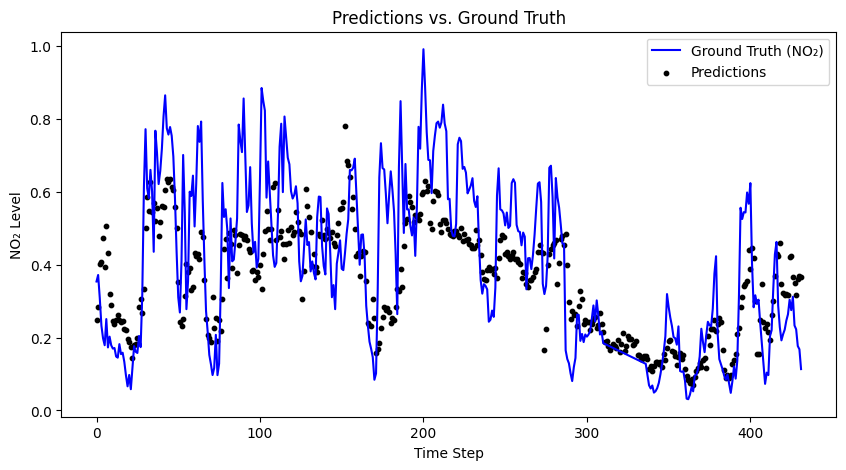

In [43]:
import torch
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
best_model.eval()

y_preds = []
y_trues = []

# Iterate through the test set and collect predictions & ground truth
with torch.no_grad():
    for batch in test_loader:
        x_test, y_true = batch  # Get input and ground truth
        x_test = x_test.to("cpu")  # Ensure data is on CPU if needed

        # Get predictions
        y_pred = best_model(x_test)

        # Store results
        y_preds.append(y_pred.cpu())
        y_trues.append(y_true.cpu())

# Convert lists to tensors
y_preds = torch.cat(y_preds, dim=0).numpy()
y_trues = torch.cat(y_trues, dim=0).numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_trues.flatten(), label="Ground Truth (NO₂)", linestyle="-", color="blue")
plt.scatter(range(len(y_preds.flatten())), y_preds.flatten(), label="Predictions", color="black", s=10)

plt.xlabel("Time Step")
plt.ylabel("NO₂ Level")
plt.title("Predictions vs. Ground Truth")
plt.legend()
plt.show()
